In [41]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [42]:
import pickle

In [ ]:
!wget http://www.romeokienzler.com/watsoniotp.healthy.pickle
!wget http://www.romeokienzler.com/watsoniotp.broken.pickle

In [43]:
data_healthy = pickle.load(open('watsoniotp.healthy.pickle', 'rb'))
data_broken = pickle.load(open('watsoniotp.broken.pickle', 'rb'))

In [44]:
data_healthy = data_healthy.reshape(3000,3)
data_broken = data_broken.reshape(3000,3)

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

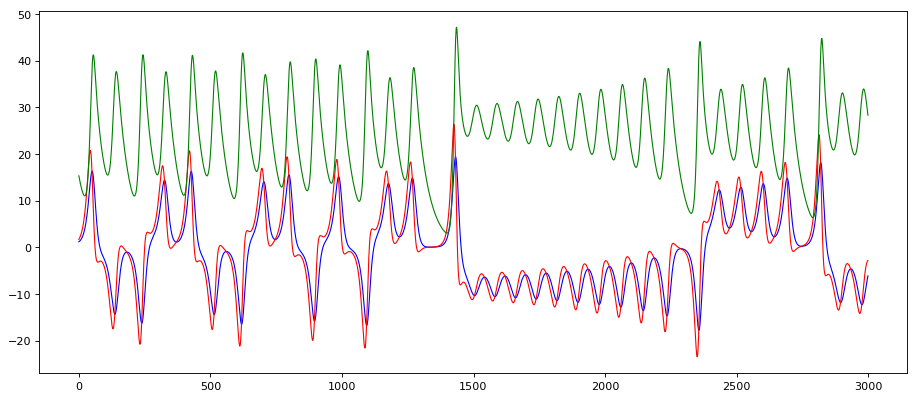

In [46]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_healthy[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,2], '-', color='green', animated = True, linewidth=1)

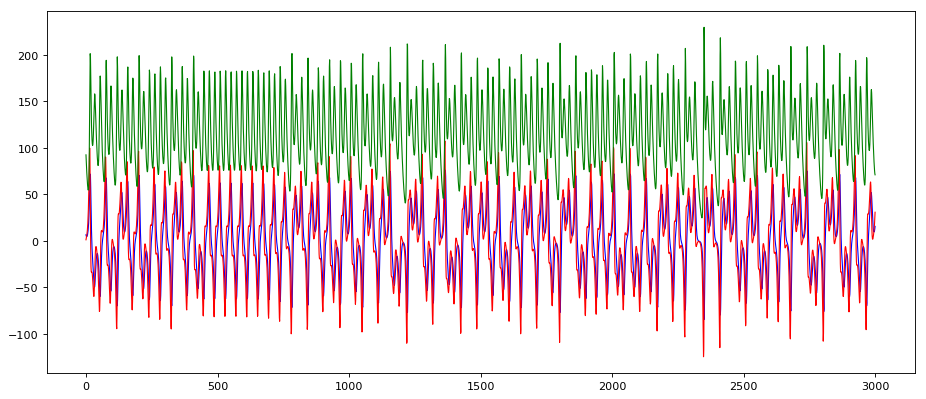

In [47]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_broken[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,2], '-', color='green', animated = True, linewidth=1)

In [48]:
import numpy as np
data_healthy_fft = np.fft.fft(data_healthy)
data_broken_fft = np.fft.fft(data_broken)

In [135]:
import numpy as np
import sklearn
from  sklearn.preprocessing import MinMaxScaler


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

data_healthy_scaled = data_healthy
data_broken_scaled = data_broken

#data_healthy_scaled = scaler.fit_transform(data_healthy)
#data_broken_scaled = scaler.fit_transform(data_broken)

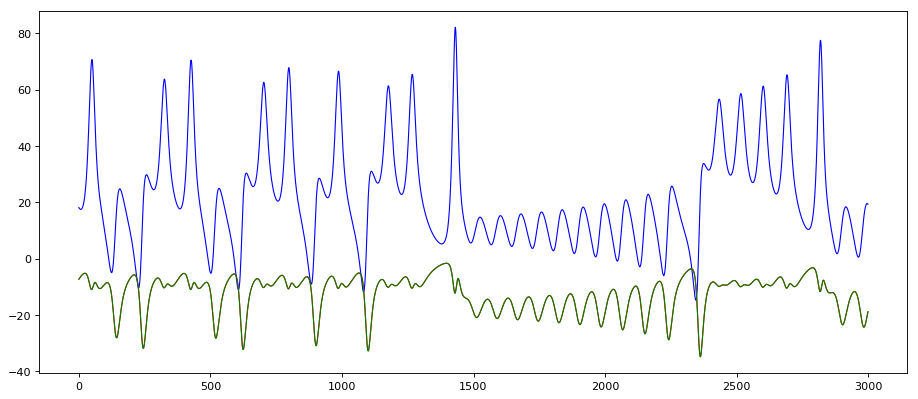

In [50]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_healthy_fft[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2], '-', color='green', animated = True, linewidth=1)


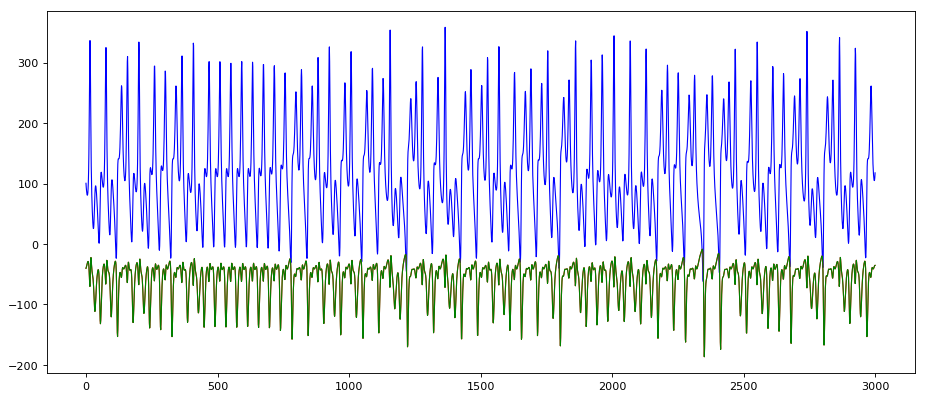

In [51]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_broken_fft[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2], '-', color='green', animated = True, linewidth=1)

In [52]:
timesteps = 10
dim = 3
samples = 3000
data_healthy_scaled_reshaped = data_healthy_scaled
data_healthy_scaled_reshaped.shape = (samples/timesteps,timesteps,dim)
#(3000,1,1)

In [139]:

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
#model.add(Activation('tanh'))
#model.add(Dense(300))
#model.add(Activation('tanh'))
#model.add(Dense(1))
#model.add(Activation('tanh'))
model.add(Dense(3))
#model.add(Activation('tanh'))
model.compile(loss='mae', optimizer='adam')

def train(data):
    data.shape = (300, 10, 3)
    model.fit(data, data, epochs=200, batch_size=300, validation_data=(data, data), verbose=0, shuffle=False)
    data.shape = (3000, 3)

def score(data):
    data.shape = (300, 10, 3)
    yhat =  model.predict(data)
    yhat.shape = (3000, 3)
    return yhat

In [137]:
import pandas as pd
def sse(y,yhat):
    return np.sum((y-yhat)**2)

for i in range(15):
    train(data_healthy_scaled)
    data_healthy_scaled.shape = (3000, 3)
    yhat_healthy = score(data_healthy_scaled)
    data_healthy_scaled.shape = (3000, 3)
    print sse(data_healthy_scaled,yhat_healthy)

train(data_broken_scaled)
data_broken_scaled.shape = (3000, 3)
yhat_broken = score(data_broken_scaled)
data_broken_scaled.shape = (3000, 3)
print sse(data_broken_scaled,yhat_broken)

#yhat_broken = score(data_broken_scaled)

#print sse(data_healthy_scaled,yhat_healthy)/3000
#df = pd.DataFrame(data_healthy_scaled)
#print sse(data_broken_scaled,yhat_broken)/3000


721855.036475
266261.337814
119826.995623
60036.8005526
32752.4714806
20435.1236312
14432.9321536
11261.7814822
9177.61276948
7664.88015136
6550.89873689
5704.01099957
5042.49220579
4526.15015715
4084.76215212
18443797.6903


In [55]:
yhat.shape = (3000,3)

In [56]:
data_healthy_scaled.shape = (3000, 3)

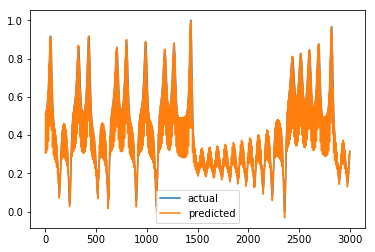

In [57]:
import matplotlib.pyplot as pyplot
pyplot.plot(data_healthy_scaled[:,0], label='actual')
pyplot.plot(yhat[:,0], label='predicted')
pyplot.legend()
pyplot.show()


In [58]:
def sse(y,yhat):
    return sum(map(lambda ((a,b,c),(x,y,z)) : pow(a-x,2)+pow(b-y,2)+pow(c-z,2),zip(y,yhat)))
print sse(data_healthy_scaled,yhat)/3000

0.0119697274994


In [59]:
import matplotlib.pyplot as pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined

In [ ]:
ts

In [ ]:
#!pip install ibmiotf

In [4]:
import ibmiotf.application

In [5]:
options = {"org": "rwyrty", "id": "anything", "auth-method": "apikey", "auth-key": "a-rwyrty-f95d3ji16n", "auth-token": "ZHd1&O)_J1&TI4XP3z"}
client = ibmiotf.application.Client(options)
client.connect()

In [6]:
client = ibmiotf.application.Client(options)
client.connect()


2017-10-03 06:17:50,886   ibmiotf.application.Client  INFO    Connected successfully: a:rwyrty:anything


In [141]:
from Queue import Queue
q = Queue(7000)

In [9]:
def myEventCallback(event):
    sample = event.data
    point = [sample["x"], sample["y"],sample["z"]]
    q.put(point)

client.deviceEventCallback = myEventCallback
client.subscribeToDeviceEvents("0.16.2", "lorenz", "osc")

True

In [140]:
def doNN(data):
    train(data)
    data.shape = (3000, 3)
    yhat = score(data)
    data.shape = (3000, 3)
    print sse(data,yhat)

In [ ]:
import numpy as np
while True:
    while not q.empty():
        point = q.get()
        try:
            data
        except NameError:
            data = np.array(point)
        else:
            data = np.append(data,point)
        if data.size>=9000:
            data = np.reshape(data,(3000,3))
            print data
            doNN(data)
            del data


('received message =', '{"x":16.186206044085054,"y":21.486381599146842,"z":33.14380530217873}')
('received message =', '{"x":16.610220088489996,"y":20.630972641061422,"z":35.17821742539341}')
('received message =', '{"x":16.93188029269571,"y":19.493599114639302,"z":37.068255080448}')
('received message =', '{"x":17.136817798451197,"y":18.094442041214055,"z":38.75811489013114}')
('received message =', '{"x":17.213427737872227,"y":16.468214238828345,"z":40.1990704319833}')
('received message =', '{"x":17.153810657948718,"y":14.66238416977194,"z":41.35361635750664}')
('received message =', '{"x":16.954496538894574,"y":12.733854357893186,"z":42.198574592314664}')
('received message =', '{"x":16.616845164414464,"y":10.744499398582985,"z":42.726655797348464}')
('received message =', '{"x":16.147057503147945,"y":8.7562061394835,"z":42.94624951935429}')
('received message =', '{"x":15.55578939405479,"y":6.826150812335087,"z":42.87955217821132}')
('received message =', '{"x":14.857418307517214,

('received message =', '{"x":-12.226032018898927,"y":-8.441671362375493,"z":35.277789396107615}')
('received message =', '{"x":-11.923283166377052,"y":-7.67993684111611,"z":35.25775704890947}')
('received message =', '{"x":-11.583815460356178,"y":-6.9459171999018485,"z":35.14927334957201}')
('received message =', '{"x":-11.212783599519831,"y":-6.249043822602111,"z":34.95997559347517}')
('received message =', '{"x":-10.815684417366413,"y":-5.596836275448495,"z":34.69843169994172}')
('received message =', '{"x":-10.39817656601298,"y":-4.994849780993927,"z":34.37369712989086}')
('received message =', '{"x":-9.965910423211456,"y":-4.446733425456597,"z":33.99491756707186}')
('received message =', '{"x":-9.524376263391067,"y":-3.9543767534385017,"z":33.57099643566997}')
('received message =', '{"x":-9.078776302594862,"y":-3.518119096034986,"z":33.11033690860599}')
('received message =', '{"x":-8.633923726070073,"y":-3.1369960705993076,"z":32.620659732976016}')
('received message =', '{"x":-8

('received message =', '{"x":-11.221977448596054,"y":-4.809643418051253,"z":36.02768079651121}')
('received message =', '{"x":-10.70899072615247,"y":-4.0834193970880355,"z":35.60892467648756}')
('received message =', '{"x":-10.178945019827315,"y":-3.431145434375537,"z":35.12867114257482}')
('received message =', '{"x":-9.639121052991173,"y":-2.8539832781785845,"z":34.599338613945825}')
('received message =', '{"x":-9.096310031006166,"y":-2.350914371696822,"z":34.032296558032066}')
('received message =', '{"x":-8.556678378261418,"y":-1.9191756844882575,"z":33.43764838412908}')
('received message =', '{"x":-8.025678162759565,"y":-1.5546957518661944,"z":32.824131787231565}')
('received message =', '{"x":-7.507999569888096,"y":-1.2525015507823203,"z":32.199113891273754}')
('received message =', '{"x":-7.007559728359634,"y":-1.007077207181778,"z":31.568656691036416}')
('received message =', '{"x":-6.527521126665405,"y":-0.8126647339678752,"z":30.937629504719943}')
('received message =', '{"

('received message =', '{"x":-12.803058215009385,"y":-4.945043930060954,"z":38.82830692272556}')
('received message =', '{"x":-12.17441707221351,"y":-3.850856981314884,"z":38.37502522018186}')
('received message =', '{"x":-11.50853226494162,"y":-2.864839625495997,"z":37.82011880959588}')
('received message =', '{"x":-10.81703685378597,"y":-1.9921242119163853,"z":37.18568065646546}')
('received message =', '{"x":-10.111043842436404,"y":-1.2331726594999162,"z":36.49213543839817}')
('received message =', '{"x":-9.400814147801485,"y":-0.5846433824291977,"z":35.75760553929335}')
('received message =', '{"x":-8.695520486571702,"y":-0.0403148922204245,"z":34.997581092891494}')
('received message =', '{"x":-8.0031040390236,"y":0.4080265829806597,"z":34.22484219602222}')
('received message =', '{"x":-7.33021358926326,"y":0.769797753167226,"z":33.44956997356374}')
('received message =', '{"x":-6.682212681868821,"y":1.0549608558465216,"z":32.67958336498254}')
('received message =', '{"x":-6.06323

('received message =', '{"x":15.431649315506922,"y":20.01024064371086,"z":32.49009833013644}')
('received message =', '{"x":15.797936621763236,"y":19.282684407801327,"z":34.23398924180212}')
('received message =', '{"x":16.076716444646284,"y":18.326646313663492,"z":35.86072250730573}')
('received message =', '{"x":16.25671083416766,"y":17.157717201162964,"z":37.32711813739306}')
('received message =', '{"x":16.328791343527282,"y":15.802050936338299,"z":38.5950334241094}')
('received message =', '{"x":16.286652110952165,"y":14.295173540988552,"z":39.63423685768389}')
('received message =', '{"x":16.127333825355077,"y":12.679778379803698,"z":40.42463462148754}')
('received message =', '{"x":15.851529389710967,"y":11.002744465893826,"z":40.95752503437791}')
('received message =', '{"x":15.463626595805595,"y":9.311759880267292,"z":41.235713122217234}')
('received message =', '{"x":14.97147725856253,"y":7.65200037714409,"z":41.27251190597466}')
('received message =', '{"x":14.38591910804905

('received message =', '{"x":-14.247827364175583,"y":-15.15940121776988,"z":34.09991094214723}')
('received message =', '{"x":-14.320753272463127,"y":-14.339283451335811,"z":35.015240898665375}')
('received message =', '{"x":-14.322235686772942,"y":-13.42077771532373,"z":35.805973425136436}')
('received message =', '{"x":-14.250119049057005,"y":-12.423523088785384,"z":36.45840612292473}')
('received message =', '{"x":-14.103991372235276,"y":-11.369756608230361,"z":36.9634983851575}')
('received message =', '{"x":-13.885252591114883,"y":-10.283115041940821,"z":37.317212951187535}')
('received message =', '{"x":-13.597081587180957,"y":-9.187354884305806,"z":37.5204821196872}')
('received message =', '{"x":-13.244303450950945,"y":-8.10511881169144,"z":37.578818392184964}')
('received message =', '{"x":-12.833168679810184,"y":-7.056865123756486,"z":37.501632457022374}')
('received message =', '{"x":-12.371064395325888,"y":-6.060047746874096,"z":37.301351558595194}')
('received message =', 

('received message =', '{"x":-10.604931866323833,"y":-18.196657443179355,"z":18.718133248903545}')
('received message =', '{"x":-11.212269912472275,"y":-18.883650546073085,"z":20.012641767769942}')
('received message =', '{"x":-11.82598036316034,"y":-19.488248074567537,"z":21.42944652239538}')
('received message =', '{"x":-12.438961780072916,"y":-19.98618899862579,"z":22.961144525250038}')
('received message =', '{"x":-13.042739957557146,"y":-20.3520633397638,"z":24.594880133300208}')
('received message =', '{"x":-13.627485828133677,"y":-20.56047261485807,"z":26.31168975055281}')
('received message =', '{"x":-14.182124771071628,"y":-20.58753944681872,"z":28.08617412785415}')
('received message =', '{"x":-14.694557945131395,"y":-20.412708805523177,"z":29.886648272005427}')
('received message =', '{"x":-15.152010013962737,"y":-20.020715026996978,"z":31.675899038808666}')
('received message =', '{"x":-15.541506415005477,"y":-19.403517238840543,"z":33.41262562710963}')
('received message =

('received message =', '{"x":11.536745900421945,"y":17.31290449482504,"z":23.843605573298905}')
('received message =', '{"x":11.998838587974193,"y":17.573376505537976,"z":25.02182285282038}')
('received message =', '{"x":12.444801621379296,"y":17.729292083813476,"z":26.25312414825794}')
('received message =', '{"x":12.86756085837403,"y":17.767281997817488,"z":27.52203015892025}')
('received message =', '{"x":13.259538549529507,"y":17.675845018101423,"z":28.80988190283415}')
('received message =', '{"x":13.61284306701526,"y":17.446239895987837,"z":30.095214495415686}')
('received message =', '{"x":13.919514813333066,"y":17.073355023171544,"z":31.354405798113465}')
('received message =', '{"x":14.171822030120145,"y":16.556463847084835,"z":32.56259388046575}')
('received message =', '{"x":14.36259337547732,"y":15.89976669116759,"z":33.6948202810174}')
('received message =', '{"x":14.485567240732543,"y":15.11262694080173,"z":34.72731723823641}')
('received message =', '{"x":14.535732016738

('received message =', '{"x":3.867019400493268,"y":7.3680445718648935,"z":9.793186324981942}')
('received message =', '{"x":4.147101414202998,"y":7.913144237208357,"z":9.846797909971013}')
('received message =', '{"x":4.448384840043427,"y":8.495858515114927,"z":9.93907567366596}')
('received message =', '{"x":4.772182734049147,"y":9.117411896842803,"z":10.075121704361038}')
('received message =', '{"x":5.11980106707264,"y":9.778647089869338,"z":10.260703597109922}')
('received message =', '{"x":5.492508748896376,"y":10.4798838386875,"z":10.502295416409515}')
('received message =', '{"x":5.891498756079666,"y":11.220746406285784,"z":10.807102555485457}')
('received message =', '{"x":6.317838568096155,"y":11.999956039613703,"z":11.183061314962007}')
('received message =', '{"x":6.772407965817559,"y":12.815085747386528,"z":11.638801250628703}')
('received message =', '{"x":7.2558221883430765,"y":13.66227665271607,"z":12.183555224589094}')
('received message =', '{"x":7.768338545492916,"y":

('received message =', '{"x":-7.03793267604488,"y":-11.221951076806446,"z":17.946674240818275}')
('received message =', '{"x":-7.372654148105806,"y":-11.725133019077516,"z":18.255374661735704}')
('received message =', '{"x":-7.7208524577835425,"y":-12.233226470869837,"z":18.621534162265913}')
('received message =', '{"x":-8.081842378830446,"y":-12.741722920349382,"z":19.048087537020198}')
('received message =', '{"x":-8.45463282215196,"y":-13.245270200430909,"z":19.53759950562911}')
('received message =', '{"x":-8.837883812414276,"y":-13.737625737574398,"z":20.092089703859273}')
('received message =', '{"x":-9.229863166427085,"y":-14.211636171399872,"z":20.71283011470814}')
('received message =', '{"x":-9.628405006824908,"y":-14.659253666101696,"z":21.400118256754446}')
('received message =', '{"x":-10.03087289956705,"y":-15.071600236122237,"z":22.153032851503365}')
('received message =', '{"x":-10.434131086491465,"y":-15.439091607719844,"z":22.969182862868355}')
('received message =',

('received message =', '{"x":-6.478314633548542,"y":-11.043232738971566,"z":15.322063203282395}')
('received message =', '{"x":-6.8435080819823835,"y":-11.648979380509385,"z":15.632951597911267}')
('received message =', '{"x":-7.227945785864543,"y":-12.27089438851699,"z":16.008995505563323}')
('received message =', '{"x":-7.631381674076739,"y":-12.904790689029781,"z":16.45532133348777}')
('received message =', '{"x":-8.053254395272981,"y":-13.545330237222373,"z":16.976946400520045}')
('received message =', '{"x":-8.492620462628933,"y":-14.185884479801386,"z":17.57857420648483}')
('received message =', '{"x":-8.948081584002729,"y":-14.818411549739007,"z":18.264335467352296}')
('received message =', '{"x":-9.417707981261632,"y":-15.433365421917111,"z":19.037471740409178}')
('received message =', '{"x":-9.898960576514071,"y":-16.019656209802438,"z":19.89996257210826}')
('received message =', '{"x":-10.38861622717714,"y":-16.564684402237123,"z":20.852103230669808}')
('received message =', 

('received message =', '{"x":-0.4187210613485479,"y":-0.7518841046625536,"z":10.530917498902486}')
('received message =', '{"x":-0.44537410481366835,"y":-0.8081112476719926,"z":10.309137220180741}')
('received message =', '{"x":-0.4743930762423343,"y":-0.8687857402146124,"z":10.09250612700272}')
('received message =', '{"x":-0.5059444893601165,"y":-0.9343170370392397,"z":9.880981030076304}')
('received message =', '{"x":-0.5402142931744464,"y":-1.0051477249497396,"z":9.6745307294435}')
('received message =', '{"x":-0.5774089677164698,"y":-1.081756865505597,"z":9.47313766946896}')
('received message =', '{"x":-0.6177567995395999,"y":-1.1646635720121092,"z":9.276799896579915}')
('received message =', '{"x":-0.6615093413374007,"y":-1.2544308375811466,"z":9.085533373856517}')
('received message =', '{"x":-0.7089430610369004,"y":-1.351669629823045,"z":8.899374716319931}')
('received message =', '{"x":-0.760361186539792,"y":-1.457043265619268,"z":8.718384422208729}')
('received message =', '

('received message =', '{"x":2.968184642689974,"y":5.684484572459162,"z":23.77851638484582}')
('received message =', '{"x":3.185488637071509,"y":5.746588600580746,"z":23.417686910148372}')
('received message =', '{"x":3.3903766341522483,"y":5.824902029617724,"z":23.076098483298075}')
('received message =', '{"x":3.5851386657894864,"y":5.919525771093323,"z":22.753586948121722}')
('received message =', '{"x":3.7718896342137933,"y":6.030480692982045,"z":22.450147554149943}')
('received message =', '{"x":3.9525769189152533,"y":6.157726596885007,"z":22.16592217715345}')
('received message =', '{"x":4.128988893152833,"y":6.3011755243685075,"z":21.901189040738902}')
('received message =', '{"x":4.302763823650087,"y":6.460700065475874,"z":21.65635460667394}')
('received message =', '{"x":4.47539872299615,"y":6.636137204891521,"z":21.431947254844086}')
('received message =', '{"x":4.64825780154778,"y":6.827288126561576,"z":21.228612342455715}')
('received message =', '{"x":4.822580227548884,"y"

('received message =', '{"x":4.897838618131933,"y":6.351926917207314,"z":19.943787021923658}')
('received message =', '{"x":5.014165682057964,"y":6.624272995005819,"z":19.784041184017084}')
('received message =', '{"x":5.142974267093792,"y":6.9093145292065925,"z":19.646257053373787}')
('received message =', '{"x":5.284281488062816,"y":7.207188246644078,"z":19.531815394363615}')
('received message =', '{"x":5.438114028749317,"y":7.5179383686865275,"z":19.442203914830742}')
('received message =', '{"x":5.604499975944294,"y":7.841492205364774,"z":19.379018040991692}')
('received message =', '{"x":5.783459354297932,"y":8.177633057754338,"z":19.34395905668162}')
('received message =', '{"x":5.974993250574444,"y":8.525970282996491,"z":19.3388288493031}')
('received message =', '{"x":6.179071413168208,"y":8.885906481227147,"z":19.365520372930526}')
('received message =', '{"x":6.395618218612923,"y":9.256601911066351,"z":19.426002806240245}')
('received message =', '{"x":6.624496914009198,"y":

('received message =', '{"x":5.4921721502530305,"y":8.223142592456783,"z":17.980281102862435}')
('received message =', '{"x":5.710649785629331,"y":8.615110296293167,"z":17.99028479480163}')
('received message =', '{"x":5.943006626482438,"y":9.022091844272389,"z":18.035438865434482}')
('received message =', '{"x":6.189333443905634,"y":9.443307041390279,"z":18.118265045043984}')
('received message =', '{"x":6.4496513317044055,"y":9.877630545153412,"z":18.24140024141344}')
('received message =', '{"x":6.723889668780326,"y":10.323535485580363,"z":18.407564878370867}')
('received message =', '{"x":7.011861334124329,"y":10.7790338011313,"z":18.619518883600595}')
('received message =', '{"x":7.313235131484887,"y":11.241614843127712,"z":18.880003061593516}')
('received message =', '{"x":7.627505508416313,"y":11.708184539458173,"z":19.191663599492365}')
('received message =', '{"x":7.953959830899661,"y":12.17500829439602,"z":19.556957658019165}')
('received message =', '{"x":8.29164370797937,"y

('received message =', '{"x":5.720842811875793,"y":9.309188283207904,"z":16.16011586124884}')
('received message =', '{"x":6.007910449582361,"y":9.803778486054622,"z":16.286568508569598}')
('received message =', '{"x":6.311579892500142,"y":10.316790327554106,"z":16.460043684812355}')
('received message =', '{"x":6.631996727304459,"y":10.84651962505816,"z":16.68436874745126}')
('received message =', '{"x":6.969158559124756,"y":11.390630895222493,"z":16.9635004498838}')
('received message =', '{"x":7.322876346012575,"y":11.946057220047308,"z":17.301448439044655}')
('received message =', '{"x":7.692730815935354,"y":12.508897380517606,"z":17.70217151516488}')
('received message =', '{"x":8.078024141101935,"y":13.074315058284867,"z":18.16944225086161}')
('received message =', '{"x":8.477727414476568,"y":13.636446849254312,"z":18.70667611716304}')
('received message =', '{"x":8.890424969258788,"y":14.18832806402334,"z":19.31672248873632}')
('received message =', '{"x":9.314257216839952,"y":1

('received message =', '{"x":3.578026110236444,"y":6.306280995617083,"z":12.573747997195747}')
('received message =', '{"x":3.796286501066895,"y":6.724330525574562,"z":12.509727921545844}')
('received message =', '{"x":4.0305300230275085,"y":7.170007934786559,"z":12.474045183858221}')
('received message =', '{"x":4.281688255968232,"y":7.6444662585000085,"z":12.469781991153232}')
('received message =', '{"x":4.550710496170774,"y":8.148698737237444,"z":12.500418926331403}')
('received message =', '{"x":4.838549555456108,"y":8.683473076249586,"z":12.569866640912887}')
('received message =', '{"x":5.146143437119586,"y":9.249250727797557,"z":12.682493253355776}')
('received message =', '{"x":5.474392020373823,"y":9.846089015621988,"z":12.843144206396277}')
('received message =', '{"x":5.824127779993677,"y":10.473524022576097,"z":13.057150267707689}')
('received message =', '{"x":6.19607947940027,"y":11.130432507115634,"z":13.330318084296769}')
('received message =', '{"x":6.590827721617499,

('received message =', '{"x":-2.7611006216883696,"y":-4.750126977539638,"z":13.799845923173043}')
('received message =', '{"x":-2.920222730156471,"y":-5.043866863374315,"z":13.623282927443821}')
('received message =', '{"x":-3.0901142608138987,"y":-5.35892151606406,"z":13.465130330053329}')
('received message =', '{"x":-3.2716188412339116,"y":-5.696470571672163,"z":13.326967659952063}')
('received message =', '{"x":-3.4656069796689715,"y":-6.0577065134234145,"z":13.210608056329402}')
('received message =', '{"x":-3.672974942369327,"y":-6.443813389491875,"z":13.11812547203097}')
('received message =', '{"x":-3.894642018139131,"y":-6.855939473138361,"z":13.051883568194869}')
('received message =', '{"x":-4.131545814539069,"y":-7.295162580385791,"z":13.01456577280971}')
('received message =', '{"x":-4.384635155806807,"y":-7.762446573643258,"z":13.009205672124716}')
('received message =', '{"x":-4.654860069233723,"y":-8.258587400437488,"z":13.039216500867974}')
('received message =', '{"x"

('received message =', '{"x":1.5148865446888296,"y":2.6253168361926607,"z":14.664333956628825}')
('received message =', '{"x":1.603720968009136,"y":2.775407799552094,"z":14.387102669684086}')
('received message =', '{"x":1.6974559145325727,"y":2.9380628818538326,"z":14.120075670459396}')
('received message =', '{"x":1.7967044719182734,"y":3.1140633557011848,"z":13.863607801945797}')
('received message =', '{"x":1.9020931826209064,"y":3.3042607306697693,"z":13.618130929979559}')
('received message =', '{"x":2.0142665864648155,"y":3.509577991373643,"z":13.384164608918258}')
('received message =', '{"x":2.1338914988575217,"y":3.7310102225604957,"z":13.16232833189658}')
('received message =', '{"x":2.2616609967537595,"y":3.969624407135114,"z":12.953355551696488}')
('received message =', '{"x":2.3982980695842677,"y":4.226558118550731,"z":12.75810966934061}')
('received message =', '{"x":2.5445588735015847,"y":4.503016751920864,"z":12.577602192930357}')
('received message =', '{"x":2.7012355

('received message =', '{"x":-1.8151601390014203,"y":-3.1331220893471783,"z":17.50751938776379}')
('received message =', '{"x":-1.920597095029081,"y":-3.2692717349004794,"z":17.184257271200114}')
('received message =', '{"x":-2.028491066218793,"y":-3.4186346610204073,"z":16.873137141696212}')
('received message =', '{"x":-2.139702553802922,"y":-3.5817509987220637,"z":16.574487936745772}')
('received message =', '{"x":-2.2550664293964533,"y":-3.7592193002723575,"z":16.28871717472013}')
('received message =', '{"x":-2.3753986590665255,"y":-3.9516972700231277,"z":16.01631939282943}')
('received message =', '{"x":-2.5015025479430535,"y":-4.159901352443526,"z":15.757885943107704}')
('received message =', '{"x":-2.634174452303091,"y":-4.384605054350748,"z":15.514116226595618}')
('received message =', '{"x":-2.774208900466904,"y":-4.626635813070933,"z":15.2858304477763}')
('received message =', '{"x":-2.922403053475226,"y":-4.886870149940927,"z":15.073983965542068}')
('received message =', '{

('received message =', '{"x":-0.10563167177314511,"y":0.47796957228083903,"z":18.08083534679145}')
('received message =', '{"x":-0.058943572248826376,"y":0.4694684477155171,"z":17.6948894822143}')
('received message =', '{"x":-0.016670610651678894,"y":0.46433836025247677,"z":17.317336580161612}')
('received message =', '{"x":0.021810107020653564,"y":0.4624875736300753,"z":16.94798076167931}')
('received message =', '{"x":0.057064304349407305,"y":0.463833079356963,"z":16.586635585259547}')
('received message =', '{"x":0.08960580635001175,"y":0.4683040444945021,"z":16.23312306153287}')
('received message =', '{"x":0.11990166540157098,"y":0.47584455727052644,"z":15.88727287265928}')
('received message =', '{"x":0.1483770967510874,"y":0.4864158110915059,"z":15.548921768436124}')
('received message =', '{"x":0.1754201938983209,"y":0.4999978490637666,"z":15.217913115133205}')
('received message =', '{"x":0.20138640631155655,"y":0.5165909746144997,"z":14.894096577209648}')
('received message 

('received message =', '{"x":5.6688168055169275,"y":-4.895397362358543,"z":33.94246760924258}')
('received message =', '{"x":4.8236796720868895,"y":-5.08555066512958,"z":33.02211309466071}')
('received message =', '{"x":4.030941245109572,"y":-5.206817002295526,"z":32.14973436135895}')
('received message =', '{"x":3.2919205853171642,"y":-5.274447234019205,"z":31.324968870243264}')
('received message =', '{"x":2.606611159770255,"y":-5.30158686385157,"z":30.54614946380762}')
('received message =', '{"x":1.9739553178805087,"y":-5.299382051134371,"z":29.81081232819585}')
('received message =', '{"x":1.3920883283593182,"y":-5.277153480380741,"z":29.116078221725015}')
('received message =', '{"x":0.8585489836601135,"y":-5.242601915121273,"z":28.458926975293853}')
('received message =', '{"x":0.3704569117576026,"y":-5.202021201160219,"z":27.836386202148283}')
('received message =', '{"x":-0.0753413372758232,"y":-5.160503646609553,"z":27.245653690468473}')
('received message =', '{"x":-0.482154

('received message =', '{"x":-4.825004685445917,"y":-2.6201025172255865,"z":25.921229538550428}')
('received message =', '{"x":-4.64861251198829,"y":-2.6764488841009513,"z":25.467777498557314}')
('received message =', '{"x":-4.490839421757303,"y":-2.7460117301012614,"z":25.0231200937626}')
('received message =', '{"x":-4.35125320642482,"y":-2.827668902157708,"z":24.5877247587801}')
('received message =', '{"x":-4.229366462083451,"y":-2.920501650657352,"z":24.16200160446279}')
('received message =', '{"x":-4.124657277169363,"y":-3.023781061547428,"z":23.74632205471488}')
('received message =', '{"x":-4.036587179919608,"y":-3.1369535479466064,"z":23.34103454268612}')
('received message =', '{"x":-3.964616489361768,"y":-3.2596260097665017,"z":22.946477808661932}')
('received message =', '{"x":-3.9082172509941464,"y":-3.3915511025401233,"z":22.562992296956416}')
('received message =', '{"x":-3.8668839591178243,"y":-3.5326129166997964,"z":22.190930095058885}')
('received message =', '{"x":-

('received message =', '{"x":-3.115791153626772,"y":-2.386203629424047,"z":22.1515348705187}')
('received message =', '{"x":-3.057424151690554,"y":-2.510163908686224,"z":21.74036587935392}')
('received message =', '{"x":-3.0136433322502074,"y":-2.640997034456822,"z":21.340243592088104}')
('received message =', '{"x":-2.9838316284267368,"y":-2.7788417926415283,"z":20.95131783037378}')
('received message =', '{"x":-2.96743244156392,"y":-2.923942963423772,"z":20.57376920898138}')
('received message =', '{"x":-2.9639532833127085,"y":-3.0766394288018026,"z":20.20781425681564}')
('received message =', '{"x":-2.972968174951836,"y":-3.237353675193792,"z":19.853710614916224}')
('received message =', '{"x":-2.9941190149711923,"y":-3.4065825253869404,"z":19.511762496587316}')
('received message =', '{"x":-3.0271160958044523,"y":-3.5848889081565773,"z":19.1823265626512}')
('received message =', '{"x":-3.0717379207926223,"y":-3.772894451856686,"z":18.865818339652638}')
('received message =', '{"x":

('received message =', '{"x":-1.802675668077509,"y":-1.1696982332633117,"z":20.609500564915944}')
('received message =', '{"x":-1.7520374732923731,"y":-1.2639281030501122,"z":20.1875468147318}')
('received message =', '{"x":-1.7129887236729922,"y":-1.3608778319104118,"z":19.775528496393726}')
('received message =', '{"x":-1.6848198523319857,"y":-1.460844832168845,"z":19.373340638132643}')
('received message =', '{"x":-1.6669018507189344,"y":-1.5641964291580424,"z":18.980901599900356}')
('received message =', '{"x":-1.658685416994063,"y":-1.6713616336502162,"z":18.598153804448554}')
('received message =', '{"x":-1.6596995143265554,"y":-1.7828246570972521,"z":18.225064815693763}')
('received message =', '{"x":-1.6695495257482111,"y":-1.899119967049898,"z":17.86162883168158}')
('received message =', '{"x":-1.6879151610523462,"y":-2.020828690540544,"z":17.507868649016263}')
('received message =', '{"x":-1.714548243411402,"y":-2.1485761840359867,"z":17.163838151347978}')
('received message 

('received message =', '{"x":-0.5739167207369262,"y":1.6707545723724646,"z":23.1602712991587}')
('received message =', '{"x":-0.394343017288175,"y":1.6421204300435175,"z":22.661005041642245}')
('received message =', '{"x":-0.2314259415016396,"y":1.6190988111238858,"z":22.174572655686553}')
('received message =', '{"x":-0.08338396129159756,"y":1.6022600429694127,"z":21.700446283383357}')
('received message =', '{"x":0.05146755904928327,"y":1.5920357438488102,"z":21.238158934887085}')
('received message =', '{"x":0.17471301383324545,"y":1.5887505109503979,"z":20.787298814062805}')
('received message =', '{"x":0.2878360136026176,"y":1.592649108116131,"z":20.34750381352558}')
('received message =', '{"x":0.3922210611636987,"y":1.603919676649683,"z":19.918456460791145}')
('received message =', '{"x":0.48915695040257745,"y":1.622713464773966,"z":19.49987948218605}')
('received message =', '{"x":0.5798414715522886,"y":1.6491615361711427,"z":19.091532071248434}')
('received message =', '{"x":0

('received message =', '{"x":2.184522565750172,"y":-2.522281571598633,"z":27.316132844171804}')
('received message =', '{"x":1.8079782347622675,"y":-2.4922119835601944,"z":26.697341756647948}')
('received message =', '{"x":1.4639630172964706,"y":-2.4570179397521623,"z":26.09902259866641}')
('received message =', '{"x":1.15028454073258,"y":-2.419868476897857,"z":25.519975151498205}')
('received message =', '{"x":0.864672299322145,"y":-2.3833542587776333,"z":24.95906245167662}')
('received message =', '{"x":0.6048301746741627,"y":-2.349573418399207,"z":24.415233709499038}')
('received message =', '{"x":0.36847788722829306,"y":-2.3202095741805655,"z":23.88753582298849}')
('received message =', '{"x":0.15338289031558436,"y":-2.2966016444528066,"z":23.375116983579698}')
('received message =', '{"x":-0.04261587246588694,"y":-2.2798055786955636,"z":22.87722506849364}')
('received message =', '{"x":-0.22159104896426104,"y":-2.2706484226314414,"z":22.393202843292176}')
('received message =', '{

('received message =', '{"x":-3.517231538946636,"y":1.3636389575873746,"z":28.127440000665047}')
('received message =', '{"x":-3.126761899223915,"y":1.355917642234808,"z":27.493470894339723}')
('received message =', '{"x":-2.768147535907217,"y":1.3338531227313393,"z":26.87740509738087}')
('received message =', '{"x":-2.439987483216133,"y":1.3012693576605852,"z":26.278619807743535}')
('received message =', '{"x":-2.1406869359459955,"y":1.2613797140844234,"z":25.696407499243342}')
('received message =', '{"x":-1.868521603943562,"y":1.2168541775369786,"z":25.130027726036204}')
('received message =', '{"x":-1.6216915414251187,"y":1.169885666030189,"z":24.57874291836848}')
('received message =', '{"x":-1.398365364828694,"y":1.1222532414449202,"z":24.041841842269392}')
('received message =', '{"x":-1.1967158763268049,"y":1.0753808898464114,"z":23.518653813229157}')
('received message =', '{"x":-1.0149481350329475,"y":1.0303911710900395,"z":23.00855618310065}')
('received message =', '{"x":-0

('received message =', '{"x":15.521192634189495,"y":7.341494666588995,"z":42.523637998870065}')
('received message =', '{"x":14.866816796781455,"y":5.555400586440483,"z":42.27719603690491}')
('received message =', '{"x":14.121903499954177,"y":3.8979879042841645,"z":41.815658593677256}')
('received message =', '{"x":13.303990252300576,"y":2.396376902974732,"z":41.178642210009585}')
('received message =', '{"x":12.431381184354509,"y":1.066576089312108,"z":40.406236620956236}')
('received message =', '{"x":11.522196776751116,"y":-0.08553331624713789,"z":39.53635265276969}')
('received message =', '{"x":10.593578369311256,"y":-1.062539097102181,"z":38.60286173327906}')
('received message =', '{"x":9.661088971998181,"y":-1.8735203088293946,"z":37.63453204514687}')
('received message =', '{"x":8.738320229531976,"y":-2.532049156536207,"z":36.6546551772499}')
('received message =', '{"x":7.836690678646521,"y":-3.0543836077195503,"z":35.681199123754226}')
('received message =', '{"x":6.96540473

('received message =', '{"x":-9.237377411782214,"y":-3.271694377445208,"z":33.585508609311034}')
('received message =', '{"x":-8.760122769035254,"y":-2.8540828932651023,"z":33.06903469128311}')
('received message =', '{"x":-8.287639578973643,"y":-2.495167569841635,"z":32.52899434726633}')
('received message =', '{"x":-7.824241818243082,"y":-2.19171865355116,"z":31.972230761801487}')
('received message =', '{"x":-7.373639965067728,"y":-1.9398665083572237,"z":31.404587523253078}')
('received message =', '{"x":-6.938938088530888,"y":-1.7353537999636635,"z":30.830955090060836}')
('received message =', '{"x":-6.52265134544551,"y":-1.5737483053473051,"z":30.255348140149668}')
('received message =', '{"x":-6.126739102237654,"y":-1.4506148817892153,"z":29.681001024508173}')
('received message =', '{"x":-5.752649164601778,"y":-1.3616482896202482,"z":29.110471015151454}')
('received message =', '{"x":-5.401369094603256,"y":-1.3027705927297522,"z":28.545741592030318}')
('received message =', '{"x

('received message =', '{"x":-8.660532202582827,"y":-1.401575839665761,"z":33.99441790949066}')
('received message =', '{"x":-8.079815693549461,"y":-1.0028928977580622,"z":33.334029178948896}')
('received message =', '{"x":-7.51366186988615,"y":-0.6742450213381701,"z":32.66343161599363}')
('received message =', '{"x":-6.966508522002311,"y":-0.40894837241070764,"z":31.989403280090766}')
('received message =', '{"x":-6.441903710034983,"y":-0.20008197110468248,"z":31.317273947117926}')
('received message =', '{"x":-5.942557970920559,"y":-0.040776573446463155,"z":30.651110640125232}')
('received message =', '{"x":-5.4704154591226315,"y":0.07557105217779307,"z":29.993913039385795}')
('received message =', '{"x":-5.026736538218597,"y":0.15514948799325934,"z":29.34780372974411}')
('received message =', '{"x":-4.612185656121649,"y":0.20363886032605766,"z":28.71420348833124}')
('received message =', '{"x":-4.226919694805832,"y":0.22616079577085996,"z":28.09398610573881}')
('received message =',

('received message =', '{"x":-16.071076145923335,"y":-12.930533983902965,"z":40.12624121055655}')
('received message =', '{"x":-15.819832772961705,"y":-11.29240884710693,"z":40.69936688791917}')
('received message =', '{"x":-15.457638858893324,"y":-9.631651759609735,"z":41.022174483760935}')
('received message =', '{"x":-14.991559890950636,"y":-7.992816876063167,"z":41.10563310459992}')
('received message =', '{"x":-14.431660449759638,"y":-6.41578596549694,"z":40.96943648828087}')
('received message =', '{"x":-13.790390491018622,"y":-4.933630928798096,"z":40.63971541957108}')
('received message =', '{"x":-13.08184972604098,"y":-3.571355019777696,"z":40.14649426145016}')
('received message =', '{"x":-12.321010149539918,"y":-2.3455275470062285,"z":39.521229866907404}')
('received message =', '{"x":-11.522971541337222,"y":-1.264692895609551,"z":38.7946944583705}')
('received message =', '{"x":-10.702309249679008,"y":-0.33035008565045576,"z":37.99535838014358}')
('received message =', '{"x

('received message =', '{"x":13.734785870604345,"y":9.197296978042388,"z":37.79517620378486}')
('received message =', '{"x":13.371786759199388,"y":8.075886542491686,"z":37.852791373338945}')
('received message =', '{"x":12.948114741862772,"y":6.9906788643147255,"z":37.769394053843676}')
('received message =', '{"x":12.471519871658929,"y":5.960039896787584,"z":37.55829302876434}')
('received message =', '{"x":11.950601473669222,"y":4.998540771570776,"z":37.23493399383813}')
('received message =', '{"x":11.394436617501347,"y":4.116737484921432,"z":36.81585197004555}')
('received message =', '{"x":10.812220686894953,"y":3.32125208869702,"z":36.31772801233634}')
('received message =', '{"x":10.212943199039119,"y":2.615094202107063,"z":35.75661228310988}')
('received message =', '{"x":9.605115279284554,"y":1.998148207242327,"z":35.147344105408806}')
('received message =', '{"x":8.996557913521176,"y":1.467751060206992,"z":34.50317175715303}')
('received message =', '{"x":8.394253365256041,"y

('received message =', '{"x":12.429156386326603,"y":20.502169390583923,"z":22.112125420340924}')
('received message =', '{"x":13.074997426667188,"y":20.954023595279903,"z":23.832190514733185}')
('received message =', '{"x":13.705319520156205,"y":21.24336069207542,"z":25.65294681815344}')
('received message =', '{"x":14.308362813909742,"y":21.34207371429403,"z":27.5486450239421}')
('received message =', '{"x":14.871059685940486,"y":21.225034138887704,"z":29.486050592888855}')
('received message =', '{"x":15.379377642176262,"y":20.872397599669263,"z":31.425050726770962}')
('received message =', '{"x":15.818819238775703,"y":20.271976352228492,"z":33.32007948082895}')
('received message =', '{"x":16.175071807851925,"y":19.42137920040356,"z":35.12238874396366}')
('received message =', '{"x":16.434776399256055,"y":18.329569235315365,"z":36.783050092442494}')
('received message =', '{"x":16.5863598261408,"y":17.01750204779868,"z":38.25641232225873}')
('received message =', '{"x":16.6208512038

('received message =', '{"x":-13.616560462705793,"y":-12.820896605467594,"z":34.68583034803472}')
('received message =', '{"x":-13.552907354126738,"y":-11.993429918285266,"z":35.2462327236025}')
('received message =', '{"x":-13.42814915925942,"y":-11.119054528097054,"z":35.68877967387146}')
('received message =', '{"x":-13.24342158876643,"y":-10.215496086078536,"z":36.009724012079516}')
('received message =', '{"x":-13.0011875485514,"y":-9.300684724644457,"z":36.208876137968886}')
('received message =', '{"x":-12.705147322638844,"y":-8.391919401357788,"z":36.28938469220391}')
('received message =', '{"x":-12.360089088936359,"y":-7.50512377984208,"z":36.2573231404423}')
('received message =', '{"x":-11.971691864208816,"y":-6.654249763518733,"z":36.121134602163515}')
('received message =', '{"x":-11.546296496153609,"y":-5.8508635413965635,"z":35.89099683897736}')
('received message =', '{"x":-11.090661859773045,"y":-5.103925611644304,"z":35.5781695446753}')
('received message =', '{"x":-

('received message =', '{"x":-14.779488708424665,"y":-14.35840269377967,"z":36.086351834841274}')
('received message =', '{"x":-14.745801827253066,"y":-13.289617538933324,"z":36.88423819507744}')
('received message =', '{"x":-14.629307084187486,"y":-12.143538608503015,"z":37.5185868900556}')
('received message =', '{"x":-14.430445606132729,"y":-10.947530696721428,"z":37.98201233965847}')
('received message =', '{"x":-14.151812413379824,"y":-9.729841922036542,"z":38.273288591285755}')
('received message =', '{"x":-13.798054774072362,"y":-8.51799199712094,"z":38.39704552913607}')
('received message =', '{"x":-13.37564975191625,"y":-7.337310145524366,"z":38.36303888286956}')
('received message =', '{"x":-12.892582583404899,"y":-6.209760987460717,"z":38.18510623753402}')
('received message =', '{"x":-12.357956855729364,"y":-5.153146071925307,"z":37.879949492424956}')
('received message =', '{"x":-11.78157199302504,"y":-4.180710213490258,"z":37.46588661015091}')
('received message =', '{"x"

('received message =', '{"x":-1.7353672513131986,"y":-3.4782366802852813,"z":6.905158596192446}')
('received message =', '{"x":-1.8747968056309652,"y":-3.766799117076201,"z":6.814344409757524}')
('received message =', '{"x":-2.026156990546584,"y":-4.080068437527448,"z":6.735106602508868}')
('received message =', '{"x":-2.1904699063050534,"y":-4.420068762411143,"z":6.668880549184897}')
('received message =', '{"x":-2.3688378147935407,"y":-4.788947911407605,"z":6.617365024713904}')
('received message =', '{"x":-2.562446622522666,"y":-5.188971214300799,"z":6.58256626495296}')
('received message =', '{"x":-2.7725685898649166,"y":-5.62250987698083,"z":6.566848538882942}')
('received message =', '{"x":-3.00056389283419,"y":-6.092022121035977,"z":6.572991782939261}')
('received message =', '{"x":-3.247880551090333,"y":-6.600024850117643,"z":6.6042566970158365}')
('received message =', '{"x":-3.5160520950125176,"y":-7.149053035835162,"z":6.664457430711529}')
('received message =', '{"x":-3.806

('received message =', '{"x":7.502524911701599,"y":10.696446547992233,"z":21.25894117925022}')
('received message =', '{"x":7.758038642604849,"y":11.029254134195888,"z":21.489940138937154}')
('received message =', '{"x":8.019735881932132,"y":11.358691786412656,"z":21.76023774737024}')
('received message =', '{"x":8.286852354290573,"y":11.681486160228703,"z":22.07044135080104}')
('received message =', '{"x":8.558423058765623,"y":11.994015642719733,"z":22.420804149001402}')
('received message =', '{"x":8.833270465481952,"y":12.292323885032097,"z":22.811145032695713}')
('received message =', '{"x":9.109994739045964,"y":12.572148825582357,"z":23.24076494927467}')
('received message =', '{"x":9.386967065968875,"y":12.828969896420604,"z":23.708362906954193}')
('received message =', '{"x":9.662327292405013,"y":13.058075754955112,"z":24.211955712299662}')
('received message =', '{"x":9.933987169409022,"y":13.254654215724818,"z":24.748806509748977}')
('received message =', '{"x":10.199640533114

('received message =', '{"x":10.04363729081157,"y":13.839396640257734,"z":24.099547454326636}')
('received message =', '{"x":10.347298038767264,"y":14.051554626944878,"z":24.748588764365145}')
('received message =', '{"x":10.643638565821472,"y":14.215996958096905,"z":25.431098338523764}')
('received message =', '{"x":10.929427237203507,"y":14.326881972741216,"z":26.14124515309188}')
('received message =', '{"x":11.201223616046525,"y":14.378829546460311,"z":26.872049137187936}')
('received message =', '{"x":11.455432090479627,"y":14.36716822617136,"z":27.615435715173817}')
('received message =', '{"x":11.688370981334966,"y":14.288190320579751,"z":28.36235177286762}')
('received message =', '{"x":11.896356528474548,"y":14.13939947098505,"z":29.102946966022678}')
('received message =', '{"x":12.075799963875388,"y":13.919732539757543,"z":29.82681934302027}')
('received message =', '{"x":12.22331456994596,"y":13.629736379501892,"z":30.523318305879208}')
('received message =', '{"x":12.33582

('received message =', '{"x":12.384177086137782,"y":15.124261736165591,"z":29.298510582434243}')
('received message =', '{"x":12.603383858140008,"y":14.87234262376206,"z":30.173010433665382}')
('received message =', '{"x":12.784900559389772,"y":14.531110104300538,"z":31.015549926022064}')
('received message =', '{"x":12.924597322982633,"y":14.103063075456651,"z":31.81209615110081}')
('received message =', '{"x":13.018874583180555,"y":13.593204957331343,"z":32.54918394406105}')
('received message =', '{"x":13.064821013112617,"y":13.008985125793625,"z":33.21448185110032}')
('received message =', '{"x":13.060354142127098,"y":12.360089407642759,"z":33.79732339741419}')
('received message =', '{"x":13.00433296336835,"y":11.658086102331218,"z":34.28915889872535}')
('received message =', '{"x":12.89663321448538,"y":10.915949609156748,"z":34.683888828596004}')
('received message =', '{"x":12.73817852605909,"y":10.14749745910759,"z":34.978050940734036}')
('received message =', '{"x":12.53092404

('received message =', '{"x":13.823885456499534,"y":14.782896950265192,"z":33.3955907943853}')
('received message =', '{"x":13.900606376000786,"y":14.064617904273282,"z":34.247205262634324}')
('received message =', '{"x":13.913727298262586,"y":13.256725677834577,"z":34.992201944625585}')
('received message =', '{"x":13.861167168628345,"y":12.375311232161794,"z":35.61799169849596}')
('received message =', '{"x":13.742298693711021,"y":11.43879900336896,"z":36.11570434974101}')
('received message =', '{"x":13.558018718483655,"y":10.467025639442266,"z":36.480533026651116}')
('received message =', '{"x":13.310739272160344,"y":9.480232122273145,"z":36.71179283956899}')
('received message =', '{"x":13.004298700169368,"y":8.498064214896946,"z":36.81269884904811}')
('received message =', '{"x":12.643799941347574,"y":7.5386716916521035,"z":36.78990092714375}')
('received message =', '{"x":12.235389681371936,"y":6.617979413284837,"z":36.65283816356338}')
('received message =', '{"x":11.7859968599

('received message =', '{"x":13.605346742735744,"y":19.014426743022433,"z":28.222182075682724}')
('received message =', '{"x":14.038073142758678,"y":18.8373592632427,"z":29.73563067529875}')
('received message =', '{"x":14.4220160323974,"y":18.486410041732924,"z":31.234160970252468}')
('received message =', '{"x":14.74716755314424,"y":17.95696105162184,"z":32.6863467098755}')
('received message =', '{"x":15.00395103302245,"y":17.25079563073896,"z":34.0596787234591}')
('received message =', '{"x":15.18369860083977,"y":16.376722582853652,"z":35.322346002166235}')
('received message =', '{"x":15.279140519400881,"y":15.350675574200654,"z":36.44516365411426}')
('received message =', '{"x":15.284863323784863,"y":14.195204792005992,"z":37.40344095028474}')
('received message =', '{"x":15.197690641242554,"y":12.93835846146499,"z":38.17856623110145}')
('received message =', '{"x":15.016944066860349,"y":11.612043915586998,"z":38.75910946336299}')
('received message =', '{"x":14.744552054758481,"

('received message =', '{"x":-7.330632114630406,"y":-13.502287648055328,"z":13.155559146683226}')
('received message =', '{"x":-7.8243645573044,"y":-14.32345588195643,"z":13.771482742547796}')
('received message =', '{"x":-8.344291863276563,"y":-15.158683441123568,"z":14.489598941872798}')
('received message =', '{"x":-8.889443189504323,"y":-15.998213514983707,"z":15.318209179179576}')
('received message =', '{"x":-9.458144815542674,"y":-16.829797519693752,"z":16.264850013950607}')
('received message =', '{"x":-10.04787703187476,"y":-17.638465891619653,"z":17.33569963746562}')
('received message =', '{"x":-10.655124140654351,"y":-18.40639371837493,"z":18.534850658941384}')
('received message =', '{"x":-11.275225706871998,"y":-19.11291612998542,"z":19.863460057807437}')
('received message =', '{"x":-11.902240940721072,"y":-19.73475727147175,"z":21.31880893085451}')
('received message =', '{"x":-12.528842247181126,"y":-20.24653992472877,"z":22.893333311808394}')
('received message =', '{

('received message =', '{"x":9.414652310126314,"y":15.020309093797733,"z":19.880969864325486}')
('received message =', '{"x":9.863104852820028,"y":15.540777385298258,"z":20.683085041984125}')
('received message =', '{"x":10.317318655418287,"y":16.02037871178744,"z":21.564144711621722}')
('received message =', '{"x":10.77356345992782,"y":16.446912445039185,"z":22.52164446401251}')
('received message =', '{"x":11.227431378736728,"y":16.807400032267847,"z":23.550814159585027}')
('received message =', '{"x":11.673828871019218,"y":17.088453104940633,"z":24.644298208587326}')
('received message =', '{"x":12.10699880973293,"y":17.276765300856724,"z":25.791911395605524}')
('received message =', '{"x":12.520580129022834,"y":17.359723580876295,"z":26.980514433395665}')
('received message =', '{"x":12.90771160517111,"y":17.326119597664192,"z":28.194054565510047}')
('received message =', '{"x":13.261184244570558,"y":17.16692349410905,"z":29.41381128438845}')
('received message =', '{"x":13.5736433

('received message =', '{"x":4.608871392288393,"y":8.468128962038728,"z":11.583014504311109}')
('received message =', '{"x":4.91761199786842,"y":9.046242849081871,"z":11.691797493848016}')
('received message =', '{"x":5.247902465965496,"y":9.658543755469214,"z":11.847869245381625}')
('received message =', '{"x":5.600753769125793,"y":10.304988263052193,"z":12.056840316320844}')
('received message =', '{"x":5.977092528639905,"y":10.984898281973628,"z":12.32488975049843}')
('received message =', '{"x":6.377716988906603,"y":11.696790431247681,"z":12.658749321546852}')
('received message =', '{"x":6.80324286429389,"y":12.438178141457941,"z":13.065655576172706}')
('received message =', '{"x":7.254037686467014,"y":13.205347094511252,"z":13.553258274439386}')
('received message =', '{"x":7.730142439110553,"y":13.993107288312164,"z":14.129471797953284}')
('received message =', '{"x":8.231179627046682,"y":14.794528903230173,"z":14.802254465463786}')
('received message =', '{"x":8.756247569141362

('received message =', '{"x":-5.283717668866764,"y":-8.995699976136171,"z":14.825307212241825}')
('received message =', '{"x":-5.580676253448317,"y":-9.511923937824033,"z":14.933697736069368}')
('received message =', '{"x":-5.895176068198374,"y":-10.052053765570802,"z":15.089181198726845}')
('received message =', '{"x":-6.227726283988169,"y":-10.614877700218216,"z":15.29613108932709}')
('received message =', '{"x":-6.578698397286573,"y":-11.198558054952331,"z":15.559189113512398}')
('received message =', '{"x":-6.948287169899833,"y":-11.800508203838568,"z":15.8832063037657}')
('received message =', '{"x":-7.336464852614932,"y":-12.417259586838332,"z":16.273154877482447}')
('received message =', '{"x":-7.742928431352804,"y":-13.044322490217322,"z":16.734004283914064}')
('received message =', '{"x":-8.167039956061966,"y":-13.676046607560357,"z":17.270554745203185}')
('received message =', '{"x":-8.607760488181837,"y":-14.305490194094675,"z":17.887222110026592}')
('received message =', '{

('received message =', '{"x":-0.6761691871639459,"y":-1.1811300254373442,"z":11.457946048044889}')
('received message =', '{"x":-0.7165660542258178,"y":-1.26650877986699,"z":11.220770163278852}')
('received message =', '{"x":-0.7605614722771116,"y":-1.3584697956143956,"z":10.989659331431275}')
('received message =', '{"x":-0.8083941381440943,"y":-1.457610514723921,"z":10.764639856060475}')
('received message =', '{"x":-0.8603314482704805,"y":-1.56457460943892,"z":10.545762627715177}')
('received message =', '{"x":-0.9166709011639557,"y":-1.680056344572864,"z":10.333106828431006}')
('received message =', '{"x":-0.9777417366366683,"y":-1.804805164300636,"z":10.126784282776217}')
('received message =', '{"x":-1.0439068108497858,"y":-1.9396304959382096,"z":9.926944565958927}')
('received message =', '{"x":-1.1155647056568596,"y":-2.085406754095473,"z":9.733780997926262}')
('received message =', '{"x":-1.1931520695319486,"y":-2.243078516101494,"z":9.547537673492709}')
('received message =',

('received message =', '{"x":3.1769024999255344,"y":5.295854215325276,"z":21.67410812355362}')
('received message =', '{"x":3.3464186371575138,"y":5.422840041378542,"z":21.35690389409749}')
('received message =', '{"x":3.512532349495196,"y":5.566130040829819,"z":21.057699638996034}')
('received message =', '{"x":3.676820164801966,"y":5.725805720162791,"z":20.776890776817183}')
('received message =', '{"x":3.8407390092308322,"y":5.901935893292794,"z":20.51499280356788}')
('received message =', '{"x":4.0056347599557895,"y":6.094578046182834,"z":20.272640853110858}')
('received message =', '{"x":4.172750222853953,"y":6.303776138631405,"z":20.050590514542858}')
('received message =', '{"x":4.343232296116149,"y":6.52955498562067,"z":19.849719576308456}')
('received message =', '{"x":4.51813811127651,"y":6.771911286534677,"z":19.671030335772883}')
('received message =', '{"x":4.698439965297164,"y":7.0308013077636184,"z":19.51565207142941}')
('received message =', '{"x":4.88502887269448,"y":7

('received message =', '{"x":4.2391555858684065,"y":5.904563305409214,"z":18.304157774175483}')
('received message =', '{"x":4.3723882034316714,"y":6.196478688330179,"z":18.130416357550438}')
('received message =', '{"x":4.518315442223552,"y":6.503657996263512,"z":17.97871876876636}')
('received message =', '{"x":4.677142846546749,"y":6.826596442884585,"z":17.850604502118802}')
('received message =', '{"x":4.849099134253776,"y":7.165707070717308,"z":17.747769397697052}')
('received message =', '{"x":5.0344277691708585,"y":7.521294329672987,"z":17.672073621480152}')
('received message =', '{"x":5.233377094011029,"y":7.893523441739427,"z":17.625547662390215}')
('received message =', '{"x":5.446188801829301,"y":8.28238506337513,"z":17.610395441202627}')
('received message =', '{"x":5.6730845027529675,"y":8.68765481976609,"z":17.628993404509895}')
('received message =', '{"x":5.914250128114017,"y":9.108847397896351,"z":17.68388422700019}')
('received message =', '{"x":6.169817909696604,"y"

('received message =', '{"x":3.8125297568134284,"y":5.958458809265256,"z":15.870842846917531}')
('received message =', '{"x":3.9842040810095747,"y":6.297391438219275,"z":15.732985607526235}')
('received message =', '{"x":4.169259069586351,"y":6.656167194814062,"z":15.619358864797634}')
('received message =', '{"x":4.368211719604568,"y":7.035567950879624,"z":15.532008678698805}')
('received message =', '{"x":4.581600218106573,"y":7.436270221328782,"z":15.473219298363412}')
('received message =', '{"x":4.80997381836435,"y":7.858807957184262,"z":15.445529237472538}')
('received message =', '{"x":5.053880549469943,"y":8.303527858291801,"z":15.451744917219813}')
('received message =', '{"x":5.313852334175691,"y":8.770536231917175,"z":15.494950367742687}')
('received message =', '{"x":5.59038704599501,"y":9.259636481851405,"z":15.578511041274297}')
('received message =', '{"x":5.883927000863522,"y":9.770256464197988,"z":15.706069278914226}')
('received message =', '{"x":6.194833357930279,"y"

('received message =', '{"x":1.4392217978501582,"y":2.321231713785733,"z":13.709840403212265}')
('received message =', '{"x":1.5097825911250042,"y":2.4752621335444713,"z":13.447260669365308}')
('received message =', '{"x":1.5870209545185616,"y":2.640224054583025,"z":13.193906502279493}')
('received message =', '{"x":1.6712772025237186,"y":2.8170629543157606,"z":12.950101241646507}')
('received message =', '{"x":1.762940062667082,"y":3.006783006362714,"z":12.716238640931357}')
('received message =', '{"x":1.8624474981627324,"y":3.210450367157521,"z":12.492793245292459}')
('received message =', '{"x":1.9702877276823154,"y":3.4291960374957213,"z":12.280332345674177}')
('received message =', '{"x":2.087000392467388,"y":3.6642180897080348,"z":12.079529719030248}')
('received message =', '{"x":2.21317780824664,"y":3.91678299717191,"z":11.891181382696738}')
('received message =', '{"x":2.3494662233606616,"y":4.188225735111314,"z":11.716223605736172}')
('received message =', '{"x":2.4965669843

('received message =', '{"x":-2.3006521791196937,"y":-3.8534068319904375,"z":18.29056100090703}')
('received message =', '{"x":-2.424872551349353,"y":-4.010932794277726,"z":17.978170372926222}')
('received message =', '{"x":-2.5517573707836227,"y":-4.1834315528804895,"z":17.68003689003898}')
('received message =', '{"x":-2.682291305351372,"y":-4.371413279028609,"z":17.396666000361638}')
('received message =', '{"x":-2.817421063245551,"y":-4.57543442520605,"z":17.12866452827185}')
('received message =', '{"x":-2.958062132202391,"y":-4.796095636087503,"z":16.87675020940364}')
('received message =', '{"x":-3.1051048125131997,"y":-5.03403772264334,"z":16.641762589674652}')
('received message =', '{"x":-3.259419445323611,"y":-5.289935499900726,"z":16.424675270157998}')
('received message =', '{"x":-3.4218607296897803,"y":-5.564489208913146,"z":16.22660945456606}')
('received message =', '{"x":-3.5932710080276498,"y":-5.858413158546599,"z":16.04884871544721}')
('received message =', '{"x":-3

('received message =', '{"x":-1.089874036721144,"y":-1.2061583379237206,"z":17.042023866245785}')
('received message =', '{"x":-1.09917678081735,"y":-1.2928670946681173,"z":16.689829406361678}')
('received message =', '{"x":-1.1146720059254114,"y":-1.3833812022545278,"z":16.34611584275671}')
('received message =', '{"x":-1.1361687416317408,"y":-1.478240383820949,"z":16.010834948911622}')
('received message =', '{"x":-1.1635344730068775,"y":-1.5780129154664662,"z":15.68395904940947}')
('received message =', '{"x":-1.1966927484036447,"y":-1.6832969472996466,"z":15.365483037024015}')
('received message =', '{"x":-1.2356210843153248,"y":-1.7947223761179916,"z":15.055426840034894}')
('received message =', '{"x":-1.280349187659538,"y":-1.912953186948734,"z":14.75383838525234}')
('received message =', '{"x":-1.3309575076026738,"y":-2.038690187437678,"z":14.460797113118792}')
('received message =', '{"x":-1.3875761219894742,"y":-2.1726740630310353,"z":14.176418113244747}')
('received message =

('received message =', '{"x":0.85011344873857,"y":2.930128720638159,"z":22.20438257096369}')
('received message =', '{"x":1.0165146704905372,"y":2.9538183320023825,"z":21.75470987346402}')
('received message =', '{"x":1.171498963411485,"y":2.9887185926218907,"z":21.318619642028935}')
('received message =', '{"x":1.3168765337483175,"y":3.035197267932588,"z":20.895798263458484}')
('received message =', '{"x":1.454342192483059,"y":3.093571212424037,"z":20.48601412295547}')
('received message =', '{"x":1.5854805140783372,"y":3.164128868253556,"z":20.089112472316277}')
('received message =', '{"x":1.7117723824123547,"y":3.2471489476296025,"z":19.705011778694583}')
('received message =', '{"x":1.8346025076297345,"y":3.342915805581094,"z":19.333701567840144}')
('received message =', '{"x":1.9552675714658432,"y":3.451731937448825,"z":18.975241743907713}')
('received message =', '{"x":2.0749847207444816,"y":3.573927965867667,"z":18.629763354082083}')
('received message =', '{"x":2.1949001803543

('received message =', '{"x":1.2871273193294432,"y":0.33886960205247996,"z":20.85369363071914}')
('received message =', '{"x":1.2112667019472863,"y":0.40540730881224984,"z":20.41274328425492}')
('received message =', '{"x":1.1467979504964834,"y":0.47177245395380896,"z":19.981599648990507}')
('received message =', '{"x":1.0927959107730694,"y":0.5380980752383746,"z":19.560029774155097}')
('received message =', '{"x":1.0484200839302937,"y":0.6045823649768636,"z":19.147819989323775}')
('received message =', '{"x":1.0129130664140193,"y":0.6714776164495522,"z":18.744774350496918}')
('received message =', '{"x":0.985598230416862,"y":0.7390812676960277,"z":18.350713328536255}')
('received message =', '{"x":0.9658768733991953,"y":0.8077288002805869,"z":17.965472776739503}')
('received message =', '{"x":0.9532250275497066,"y":0.8777882697890683,"z":17.588903195483613}')
('received message =', '{"x":0.9471900869288555,"y":0.9496562651291126,"z":17.22086930064919}')
('received message =', '{"x":0.

('received message =', '{"x":2.0049201471985123,"y":-3.467866309684736,"z":28.086173474023923}')
('received message =', '{"x":1.5670972306478523,"y":-3.4412037169072436,"z":27.443860166725862}')
('received message =', '{"x":1.1664331548434448,"y":-3.408484487649905,"z":26.826584995322396}')
('received message =', '{"x":0.8004397434439767,"y":-3.3737026277063262,"z":26.232680950095965}')
('received message =', '{"x":0.4665083537519525,"y":-3.340117253880474,"z":25.660584882349013}')
('received message =', '{"x":0.16197830514135836,"y":-3.310364839883197,"z":25.108869413236256}')
('received message =', '{"x":-0.11580914646060608,"y":-3.2865604760886056,"z":24.576258442528765}')
('received message =', '{"x":-0.3694692528308461,"y":-3.2703877301608952,"z":24.06163139077719}')
('received message =', '{"x":-0.6015427310172501,"y":-3.263177404391164,"z":23.564020112954992}')
('received message =', '{"x":-0.8144735048871632,"y":-3.2659758898457185,"z":23.08260142385099}')
('received message ='

('received message =', '{"x":-2.8017572632804817,"y":-0.33196562592599477,"z":24.77040345859056}')
('received message =', '{"x":-2.604173932292123,"y":-0.3965933499182609,"z":24.250230569315917}')
('received message =', '{"x":-2.427567485702214,"y":-0.46624314990938504,"z":23.74194701085972}')
('received message =', '{"x":-2.2706615388387874,"y":-0.5398619819323368,"z":23.245258892003953}')
('received message =', '{"x":-2.1321975742862715,"y":-0.6166474657315052,"z":22.75987854948618}')
('received message =', '{"x":-2.0109535656018904,"y":-0.6960154133264349,"z":22.28553171118095}')
('received message =', '{"x":-1.905758513419854,"y":-0.777570462748501,"z":21.821961926909093}')
('received message =', '{"x":-1.8155034693661458,"y":-0.8610798954910943,"z":21.368933087436357}')
('received message =', '{"x":-1.7391495834561417,"y":-0.9464505943980045,"z":20.926230668160454}')
('received message =', '{"x":-1.6757336643314906,"y":-1.033709016867454,"z":20.493662181895868}')
('received messag

('received message =', '{"x":-3.1393277572971314,"y":2.2237730673396796,"z":28.432414502978183}')
('received message =', '{"x":-2.7102796913261864,"y":2.2153585967662157,"z":27.777822395604087}')
('received message =', '{"x":-2.316228628278794,"y":2.1935188149691722,"z":27.144583322557335}')
('received message =', '{"x":-1.9554488328189568,"y":2.162588876101586,"z":26.53166822319366}')
('received message =', '{"x":-1.6260058161053133,"y":2.1261880370202983,"z":25.93800174818423}')
('received message =', '{"x":-1.3258303078552642,"y":2.0873076545081206,"z":25.36251838488831}')
('received message =', '{"x":-1.0527792708661934,"y":2.0483957054986135,"z":24.80419925771245}')
('received message =', '{"x":-0.8046852727570089,"y":2.011435629518747,"z":24.26209442585587}')
('received message =', '{"x":-0.5793956005749483,"y":1.9780183361224075,"z":23.73533463712983}')
('received message =', '{"x":-0.37480248563915985,"y":1.9494069320060445,"z":23.223135691028624}')
('received message =', '{"x"

('received message =', '{"x":6.153567550012864,"y":-1.532569363653608,"z":32.254283385577004}')
('received message =', '{"x":5.538676596919546,"y":-1.7088136073392513,"z":31.490475479200953}')
('received message =', '{"x":4.958877380578842,"y":-1.8336138176907348,"z":30.745937340295892}')
('received message =', '{"x":4.415478084717276,"y":-1.9159419163338758,"z":30.02234561402427}')
('received message =', '{"x":3.908964484633184,"y":-1.9638565984502012,"z":29.320455742021718}')
('received message =', '{"x":3.439138797986513,"y":-1.9844755902498874,"z":28.640353590223235}')
('received message =', '{"x":3.0052496469276013,"y":-1.9839951647353058,"z":27.98166017415186}')
('received message =', '{"x":2.6061100619945687,"y":-1.9677408385799988,"z":27.34369289684605}')
('received message =', '{"x":2.2402019899486034,"y":-1.9402368280433357,"z":26.725588602488102}')
('received message =', '{"x":1.9057668845092484,"y":-1.9052850851100345,"z":26.126394478535673}')
('received message =', '{"x":1

('received message =', '{"x":-11.1654535344154,"y":-1.5176913187943302,"z":38.05605356516618}')
('received message =', '{"x":-10.393632557165715,"y":-0.6693983823918669,"z":37.29985093567684}')
('received message =', '{"x":-9.615693823183808,"y":0.05135295825701136,"z":36.50017042779429}')
('received message =', '{"x":-8.842330080668543,"y":0.6522326359069123,"z":35.67536207528609}')
('received message =', '{"x":-8.082765063342507,"y":1.1433199622646684,"z":34.84035819116893}')
('received message =', '{"x":-7.344678261293932,"y":1.5360952434156898,"z":34.006840213691255}')
('received message =', '{"x":-6.634216380917162,"y":1.8426119034141442,"z":33.18356666721275}')
('received message =', '{"x":-5.956070118170658,"y":2.0748605004438816,"z":32.37678646130368}')
('received message =', '{"x":-5.3135956686814945,"y":2.2443134051085467,"z":31.590678691554146}')
('received message =', '{"x":-4.7089629427782915,"y":2.361625881051295,"z":30.827777742732376}')
('received message =', '{"x":-4.1

('received message =', '{"x":11.60719931394499,"y":3.243851501626794,"z":37.755662467908444}')
('received message =', '{"x":10.938131488959534,"y":2.3642309389266596,"z":37.1570904863017}')
('received message =', '{"x":10.252219444956905,"y":1.5942730822721092,"z":36.49516458921773}')
('received message =', '{"x":9.559583735942121,"y":0.9318369996840343,"z":35.787864868594916}')
('received message =', '{"x":8.869363997041475,"y":0.37179503745184295,"z":35.05077110222052}')
('received message =', '{"x":8.189558480274304,"y":-0.09312094102907642,"z":34.29692036356812}')
('received message =', '{"x":7.526944126570033,"y":-0.47154851546915016,"z":33.53685817451411}')
('received message =', '{"x":6.887064715206899,"y":-0.772837731879805,"z":32.77882453233399}')
('received message =', '{"x":6.274272519439962,"y":-1.006524209532356,"z":32.02902128480671}')
('received message =', '{"x":5.691808781122177,"y":-1.181931365681625,"z":31.291916878790538}')
('received message =', '{"x":5.14190956937

('received message =', '{"x":-14.359244441281282,"y":-21.56360864507939,"z":27.435092298401916}')
('received message =', '{"x":-14.93559357758513,"y":-21.45859763063809,"z":29.413785473018475}')
('received message =', '{"x":-15.457433901829367,"y":-21.112100885588585,"z":31.397002614669326}')
('received message =', '{"x":-15.909807260530105,"y":-20.51083882360063,"z":33.33778783170532}')
('received message =', '{"x":-16.27788978557575,"y":-19.651648736825532,"z":35.185680669238764}')
('received message =', '{"x":-16.54779050167573,"y":-18.543178440318894,"z":36.88984187148637}')
('received message =', '{"x":-16.707421536767185,"y":-17.206622328459336,"z":38.40268491795216}')
('received message =', '{"x":-16.747357600102557,"y":-15.675229475254554,"z":39.68357702758856}')
('received message =', '{"x":-16.66158735011472,"y":-13.992492125796833,"z":40.70209108939806}')
('received message =', '{"x":-16.448059732169288,"y":-12.209154165095462,"z":41.440314988718264}')
('received message =',

('received message =', '{"x":13.683975213992275,"y":13.980285147639146,"z":33.80899130269718}')
('received message =', '{"x":13.707680008684024,"y":13.23142051485322,"z":34.538709449396535}')
('received message =', '{"x":13.66957924917756,"y":12.410517894687416,"z":35.15905611088753}')
('received message =', '{"x":13.568854340818348,"y":11.53411223483889,"z":35.66103375811004}')
('received message =', '{"x":13.406074972339992,"y":10.620204193545373,"z":36.03926706705885}')
('received message =', '{"x":13.183205310036422,"y":9.687376093699001,"z":36.292114713298446}')
('received message =', '{"x":12.903538972729429,"y":8.753896081994291,"z":36.421532846805974}')
('received message =', '{"x":12.571567541470618,"y":7.83688996144766,"z":36.43271607779741}')
('received message =', '{"x":12.192793335068782,"y":6.951647926636914,"z":36.33356485353221}')
('received message =', '{"x":11.773501702394233,"y":6.111112823303225,"z":36.134042381152994}')
('received message =', '{"x":11.3205105920669

('received message =', '{"x":14.473737450797582,"y":17.2457662176435,"z":32.666792114387384}')
('received message =', '{"x":14.695499752145256,"y":16.559153349020004,"z":33.916660820770524}')
('received message =', '{"x":14.844592039895236,"y":15.724036793245682,"z":35.0604406812557}')
('received message =', '{"x":14.914947620163272,"y":14.755795675410127,"z":36.0731399701295}')
('received message =', '{"x":14.90221546458302,"y":13.675287939521988,"z":36.933916350086506}')
('received message =', '{"x":14.804061262578136,"y":12.50781967631438,"z":37.627325031280165}')
('received message =', '{"x":14.620361935677035,"y":11.281717307466112,"z":38.14415108627536}')
('received message =', '{"x":14.353270365420162,"y":10.026649623654537,"z":38.48173089969603}')
('received message =', '{"x":14.007140706078912,"y":8.77188379022292,"z":38.64373939122539}')
('received message =', '{"x":13.588320152810432,"y":7.544664412132736,"z":38.63949414136651}')
('received message =', '{"x":13.1048276935562

('received message =', '{"x":-1.70780504659628,"y":-3.3912077545813775,"z":7.365569572420456}')
('received message =', '{"x":-1.8424772632350876,"y":-3.668225843765699,"z":7.2625064032505495}')
('received message =', '{"x":-1.9885371496775366,"y":-3.968778248282264,"z":7.1707094371988696}')
('received message =', '{"x":-2.146956437565915,"y":-4.2947846580059,"z":7.091500027094348}')
('received message =', '{"x":-2.3187826952011137,"y":-4.648284524100146,"z":7.026441586917838}')
('received message =', '{"x":-2.5051428415130363,"y":-5.031432325664051,"z":6.977379819782481}')
('received message =', '{"x":-2.7072460002451173,"y":-5.446488102239268,"z":6.946488915335147}')
('received message =', '{"x":-2.9263853684046492,"y":-5.895801691755021,"z":6.936324254254135}')
('received message =', '{"x":-3.163938674272679,"y":-6.381788704735419,"z":6.949882041581638}')
('received message =', '{"x":-3.421366676709698,"y":-6.906895772087463,"z":6.990666075634247}')
('received message =', '{"x":-3.70

('received message =', '{"x":6.922942011765959,"y":10.030288970184518,"z":20.541112758578336}')
('received message =', '{"x":7.171529768439443,"y":10.377979713553351,"z":20.698310276678065}')
('received message =', '{"x":7.428045764048556,"y":10.72885415920267,"z":20.894301681631813}')
('received message =', '{"x":7.692110435660885,"y":11.080285855428073,"z":21.130402838759487}')
('received message =', '{"x":7.96316446924226,"y":11.429273424843831,"z":21.40772638390039}')
('received message =', '{"x":8.240453185690386,"y":11.772425814410926,"z":21.72710921148918}')
('received message =', '{"x":8.52301099598803,"y":12.105957745232518,"z":22.08903123614741}')
('received message =', '{"x":8.809646735927588,"y":12.425698456683808,"z":22.493526680580626}')
('received message =', '{"x":9.098930873588086,"y":12.72711702975557,"z":22.940090042652066}')
('received message =', '{"x":9.389185766081486,"y":13.005367569911007,"z":23.42757995163602}')
('received message =', '{"x":9.678480310387847,"

('received message =', '{"x":9.544432365197446,"y":13.630756804931538,"z":22.77720719187557}')
('received message =', '{"x":9.871338320376173,"y":13.934158388781876,"z":23.39168377177188}')
('received message =', '{"x":10.19636392584863,"y":14.198589676458885,"z":24.050853085240526}')
('received message =', '{"x":10.516541985897451,"y":14.417251913747577,"z":24.750725299999555}')
('received message =', '{"x":10.82859878012546,"y":14.583394634859335,"z":25.486051661757905}')
('received message =', '{"x":11.128982448504171,"y":14.6905489732424,"z":26.250276119763914}')
('received message =', '{"x":11.41390777048323,"y":14.732794077399074,"z":27.035540251616588}')
('received message =', '{"x":11.679418675036496,"y":14.705046358352604,"z":27.832753204022268}')
('received message =', '{"x":11.921468889701785,"y":14.60335660728699,"z":28.631735494168403}')
('received message =', '{"x":12.1360199071086,"y":14.425195718162655,"z":29.421440836155956}')
('received message =', '{"x":12.3191539719

('received message =', '{"x":11.902538097718827,"y":11.937031757230706,"z":92.01107359984495}')
('received message =', '{"x":11.910816576001677,"y":15.270795512128629,"z":86.59601459223994}')
('received message =', '{"x":12.717211520672146,"y":19.36097506986606,"z":82.09991975769893}')
('received message =', '{"x":14.311714772478686,"y":24.46135812100071,"z":78.77046425879247}')
('received message =', '{"x":16.747629176123972,"y":30.861491328884586,"z":77.02379076158923}')
('received message =', '{"x":20.13495609278652,"y":38.825829276590305,"z":77.52673199339193}')
('received message =', '{"x":24.62076565689943,"y":48.456746670606194,"z":81.28240697206724}')
('received message =', '{"x":30.341401100189053,"y":59.40891052520857,"z":89.63371725018432}')
('received message =', '{"x":37.317603362193736,"y":70.38754101812208,"z":103.95462106100592}')
('received message =', '{"x":45.25438839961654,"y":78.52971203174668,"z":124.62318873534178}')
('received message =', '{"x":53.24046607132777

('received message =', '{"x":44.48883536636632,"y":69.81591815659358,"z":129.65394545952216}')
('received message =', '{"x":50.56733523602086,"y":68.58830589523082,"z":147.7197403916769}')
('received message =', '{"x":54.89236819423125,"y":59.379893445872305,"z":162.76602357068538}')
('received message =', '{"x":55.96937425462511,"y":43.338193621722866,"z":170.01771977074313}')
('received message =', '{"x":52.93789090272857,"y":25.196852351108916,"z":167.99400912803563}')
('received message =', '{"x":46.280041650339854,"y":10.187882266623555,"z":159.22242137150042}')
('received message =', '{"x":37.61792339824794,"y":0.7101979648031893,"z":147.5475432901955}')
('received message =', '{"x":28.760069294221196,"y":-3.7929932153777273,"z":135.65796607620672}')
('received message =', '{"x":20.947334291917457,"y":-5.04596107281043,"z":124.68324247518731}')
('received message =', '{"x":14.708943404382765,"y":-4.6153053944797024,"z":114.83047024364257}')
('received message =', '{"x":10.0711236

('received message =', '{"x":-68.42613171640457,"y":-37.69893260147896,"z":195.7676759570396}')
('received message =', '{"x":-61.05160392882242,"y":-4.2987386470194195,"z":183.2499152664181}')
('received message =', '{"x":-47.4309162611897,"y":16.700084097671166,"z":163.23045260339381}')
('received message =', '{"x":-32.03947617506309,"y":25.596605399474804,"z":144.48176417813536}')
('received message =', '{"x":-18.206816597173997,"y":27.79247621699247,"z":129.64569231472177}')
('received message =', '{"x":-7.166986321774045,"y":27.664493641732207,"z":118.37931224165641}')
('received message =', '{"x":1.1925688694674559,"y":27.534964354386087,"z":109.80302232476689}')
('received message =', '{"x":7.514743785847927,"y":28.40864963880037,"z":103.312266444551}')
('received message =', '{"x":12.529281190556514,"y":30.65593688708003,"z":98.67105871070329}')
('received message =', '{"x":16.87967855772216,"y":34.37119420319646,"z":95.9450173386641}')
('received message =', '{"x":21.0776423126

('received message =', '{"x":-27.27914077810306,"y":41.11998590559342,"z":140.25413836074787}')
('received message =', '{"x":-10.863350374015905,"y":41.85599400670446,"z":126.14425873796505}')
('received message =', '{"x":1.7892922773569797,"y":41.54770976272228,"z":117.32021538862612}')
('received message =', '{"x":11.331312473844651,"y":42.183455897299176,"z":112.38425733293357}')
('received message =', '{"x":18.735826895473735,"y":44.18657906175614,"z":110.61587622330835}')
('received message =', '{"x":24.844007415381512,"y":47.288216829406394,"z":111.75518794186085}')
('received message =', '{"x":30.230617674747485,"y":50.838636714993,"z":115.70586769262592}')
('received message =', '{"x":35.176542244406406,"y":53.891648137022386,"z":122.23227093674441}')
('received message =', '{"x":39.66816765863424,"y":55.290876899852606,"z":130.65189690565091}')
('received message =', '{"x":43.41761787652665,"y":53.927437512673826,"z":139.62776226991332}')
('received message =', '{"x":45.939974

('received message =', '{"x":-32.23450228533992,"y":-63.036489314465754,"z":92.61796158133484}')
('received message =', '{"x":-39.626979172330124,"y":-73.74886379587825,"z":109.0820446335734}')
('received message =', '{"x":-47.816231481981674,"y":-80.39555554924604,"z":131.69095192172205}')
('received message =', '{"x":-55.63526925812512,"y":-78.10961427298167,"z":156.62322288537183}')
('received message =', '{"x":-61.0291120616907,"y":-63.50993834249296,"z":175.9363300630113}')
('received message =', '{"x":-61.62451036908324,"y":-39.369435883562325,"z":182.20872843029213}')
('received message =', '{"x":-56.28329249255822,"y":-14.646114653359522,"z":175.19846248014693}')
('received message =', '{"x":-46.290369811150526,"y":2.949728525657072,"z":161.02462508726796}')
('received message =', '{"x":-34.4727462103167,"y":12.033726852045787,"z":145.68276818687318}')
('received message =', '{"x":-23.3111926753497,"y":15.235108367131378,"z":131.9639331229784}')
('received message =', '{"x":-14

('received message =', '{"x":-37.23393552306741,"y":5.487781398022063,"z":148.30592373503674}')
('received message =', '{"x":-26.980723462005933,"y":9.826827250322758,"z":135.11133549442175}')
('received message =', '{"x":-18.146911291047047,"y":10.78060282734534,"z":123.45794529879682}')
('received message =', '{"x":-11.204307902632873,"y":10.287233369663525,"z":113.31766140870039}')
('received message =', '{"x":-6.0463379972817375,"y":9.49474044899797,"z":104.39734207724193}')
('received message =', '{"x":-2.316479170174608,"y":8.98138200189538,"z":96.43589906086036}')
('received message =', '{"x":0.3950075111221891,"y":9.00927540150245,"z":89.26382178260968}')
('received message =', '{"x":2.4624318048134515,"y":9.700282776205821,"z":82.78988003476533}')
('received message =', '{"x":4.19951603794762,"y":11.141565504968487,"z":76.98254912304387}')
('received message =', '{"x":5.865607910032628,"y":13.446419888237338,"z":71.86549020338778}')
('received message =', '{"x":7.6850027848017

('received message =', '{"x":4.575101563177792,"y":0.7716866084044984,"z":86.91612220326724}')
('received message =', '{"x":3.6622819740322012,"y":1.9691990761637919,"z":80.48407917699593}')
('received message =', '{"x":3.255942078543783,"y":3.191118171621471,"z":74.55772203257428}')
('received message =', '{"x":3.240384340882428,"y":4.550977391582358,"z":69.10872078114521}')
('received message =', '{"x":3.5549266730504114,"y":6.1894030068910295,"z":64.12462595353534}')
('received message =', '{"x":4.187200993172159,"y":8.279560020008702,"z":59.61399933784851}')
('received message =', '{"x":5.169367159612929,"y":11.041422307850183,"z":55.61943804761144}')
('received message =', '{"x":6.57866039518987,"y":14.762428019769505,"z":52.24345601112711}')
('received message =', '{"x":8.542764625088981,"y":19.821691188468474,"z":49.697267633983905}')
('received message =', '{"x":11.24970700030006,"y":26.710180030485475,"z":48.39039191145893}')
('received message =', '{"x":14.960220527544559,"y"

('received message =', '{"x":28.549890825260942,"y":50.3198866497216,"z":115.55590138042061}')
('received message =', '{"x":33.7746898231315,"y":53.279692124561855,"z":121.32376801371468}')
('received message =', '{"x":38.45589037547479,"y":54.90737815065197,"z":129.15702358842034}')
('received message =', '{"x":42.40424744151731,"y":54.07561740913437,"z":137.857586049843}')
('received message =', '{"x":45.205376233745405,"y":50.07808538074391,"z":145.6746091504053}')
('received message =', '{"x":46.37482642902504,"y":43.12020524529073,"z":150.79510793784937}')
('received message =', '{"x":45.593717344928805,"y":34.46073393800482,"z":152.10528357983543}')
('received message =', '{"x":42.92180132726705,"y":25.907910524491754,"z":149.6442025792358}')
('received message =', '{"x":38.83846753460098,"y":18.975625966808007,"z":144.3666426511377}')
('received message =', '{"x":34.07138555833067,"y":14.362747422574886,"z":137.50213630741118}')
('received message =', '{"x":29.341312405749278,"y

('received message =', '{"x":56.70301208391562,"y":59.36553704763922,"z":167.03866161739822}')
('received message =', '{"x":57.34201807520928,"y":40.98216763048349,"z":173.36644312619336}')
('received message =', '{"x":53.41565396847509,"y":21.268084466965618,"z":169.51013782978214}')
('received message =', '{"x":45.70023728811282,"y":5.921754601763396,"z":159.01838559552556}')
('received message =', '{"x":36.15340144338896,"y":-3.096980607537663,"z":146.2492817390594}')
('received message =', '{"x":26.733309751166573,"y":-6.9751143744100235,"z":133.8375922242423}')
('received message =', '{"x":18.64328796102819,"y":-7.789968762099607,"z":122.68254029145163}')
('received message =', '{"x":12.299306347477518,"y":-7.204440484436371,"z":112.81336698504789}')
('received message =', '{"x":7.618407107818185,"y":-6.2212213373213805,"z":104.01080254198651}')
('received message =', '{"x":4.29689628098469,"y":-5.346818819893645,"z":96.06086481163311}')
('received message =', '{"x":1.982404656773

('received message =', '{"x":13.094093435849349,"y":34.154614825897475,"z":35.42850376951041}')
('received message =', '{"x":18.1486185694609,"y":47.32173611122184,"z":39.65376859787162}')
('received message =', '{"x":25.150166779483527,"y":64.71854185515105,"z":49.71441084695348}')
('received message =', '{"x":34.64657679764373,"y":85.89941493422833,"z":69.81136691484554}')
('received message =', '{"x":46.94725795042403,"y":107.0665937526051,"z":104.81064881008487}')
('received message =', '{"x":61.37589854294749,"y":117.59619912985633,"z":154.7253661269077}')
('received message =', '{"x":74.86877068380561,"y":100.6482670728479,"z":203.4558350070277}')
('received message =', '{"x":81.05584981717575,"y":50.913986294991275,"z":221.2794774069341}')
('received message =', '{"x":73.82180257185148,"y":-4.581798916490008,"z":202.05138318691996}')
('received message =', '{"x":55.00493821464953,"y":-37.130678580405046,"z":170.62591445949775}')
('received message =', '{"x":32.892390183836426,"y

('received message =', '{"x":16.344930036893086,"y":1.8089858973472408,"z":112.96682297280599}')
('received message =', '{"x":12.856303443402084,"y":3.340682694808363,"z":104.87555750096377}')
('received message =', '{"x":10.572554463739591,"y":5.2698326553672965,"z":97.49057394966778}')
('received message =', '{"x":9.29990122973024,"y":7.497551184875146,"z":90.7690896452994}')
('received message =', '{"x":8.867337218965018,"y":10.078683072069637,"z":84.70663293730198}')
('received message =', '{"x":9.158060223710127,"y":13.169919710272096,"z":79.34675835410155}')
('received message =', '{"x":10.120906500484999,"y":17.003879629739046,"z":74.79895780402002}')
('received message =', '{"x":11.77282005150597,"y":21.87845896330792,"z":71.27453823768745}')
('received message =', '{"x":14.19817339033844,"y":28.14661482558807,"z":69.14975019043162}')
('received message =', '{"x":17.54579933479835,"y":36.1820392986749,"z":69.06531125134609}')
('received message =', '{"x":22.018496926128723,"y":

('received message =', '{"x":-19.359896543852997,"y":-29.28601922377157,"z":90.85789376882471}')
('received message =', '{"x":-21.742165987033456,"y":-35.512129780271344,"z":90.25072266263834}')
('received message =', '{"x":-25.04695729741055,"y":-42.79206904184522,"z":92.08649104483287}')
('received message =', '{"x":-29.305784116074868,"y":-50.86952081183725,"z":97.1368692734844}')
('received message =', '{"x":-34.48108092305784,"y":-58.976117510301734,"z":106.15246527760142}')
('received message =', '{"x":-40.35988970399637,"y":-65.55842130382122,"z":119.39385976079666}')
('received message =', '{"x":-46.407537287954334,"y":-68.22907212584019,"z":135.80986390241014}')
('received message =', '{"x":-51.64470564904694,"y":-64.45653456964075,"z":152.30010410441724}')
('received message =', '{"x":-54.719544589989454,"y":-53.30335725241926,"z":164.26224646971323}')
('received message =', '{"x":-54.379659628972604,"y":-37.10150143116056,"z":168.1378682230441}')
('received message =', '{"x"

('received message =', '{"x":-31.567480736114586,"y":-68.59416836974351,"z":81.56573262187156}')
('received message =', '{"x":-40.45388576818553,"y":-83.0729874087391,"z":102.36049239721218}')
('received message =', '{"x":-50.68247016191839,"y":-92.80419214182577,"z":132.34594122458589}')
('received message =', '{"x":-60.79168343709616,"y":-89.94818193940115,"z":166.20892216410272}')
('received message =', '{"x":-67.78924307764936,"y":-68.5073651853472,"z":190.95115542512008}')
('received message =', '{"x":-67.96159238349684,"y":-33.733220143287085,"z":195.0339760106645}')
('received message =', '{"x":-59.7467830458465,"y":-1.4228390108635836,"z":181.15151956473142}')
('received message =', '{"x":-45.7490364774506,"y":18.041590160413943,"z":161.02245650635155}')
('received message =', '{"x":-30.43928608436311,"y":25.938697445572814,"z":142.68300296293174}')
('received message =', '{"x":-16.908570037178492,"y":27.717336537646876,"z":128.2800545329727}')
('received message =', '{"x":-6.1

('received message =', '{"x":-73.40722124348932,"y":-78.1669308954423,"z":203.10796177264407}')
('received message =', '{"x":-74.54955155995803,"y":-32.74747649841407,"z":207.47304479503626}')
('received message =', '{"x":-64.51705354518748,"y":8.533436805096741,"z":187.57730652277567}')
('received message =', '{"x":-46.98493586111927,"y":30.859056716662828,"z":161.97224789787205}')
('received message =', '{"x":-28.302377642451564,"y":38.304147377877975,"z":141.20553249994435}')
('received message =', '{"x":-12.316811637572474,"y":39.2989146498602,"z":126.78988743885492}')
('received message =', '{"x":0.07096267141136892,"y":38.9852103152217,"z":117.34504113410976}')
('received message =', '{"x":9.410382105925848,"y":39.47546650670752,"z":111.55511185186526}')
('received message =', '{"x":16.62600236211345,"y":41.3469647682185,"z":108.7251413714803}')
('received message =', '{"x":22.55903333957866,"y":44.49476647740428,"z":108.63706884561401}')
('received message =', '{"x":27.823609292

('received message =', '{"x":-18.65666936777541,"y":-28.251217979596863,"z":89.89132398433006}')
('received message =', '{"x":-20.95936103461256,"y":-34.41507622906814,"z":88.94998252191677}')
('received message =', '{"x":-24.1887326812819,"y":-41.696319091049524,"z":90.37703275724161}')
('received message =', '{"x":-28.39055341962613,"y":-49.90784342880414,"z":94.96417133742465}')
('received message =', '{"x":-33.55470302182885,"y":-58.37664004019561,"z":103.54399977058468}')
('received message =', '{"x":-39.511967906236876,"y":-65.64006448931069,"z":116.56125942610072}')
('received message =', '{"x":-45.782711086174594,"y":-69.30451641247247,"z":133.24160793731937}')
('received message =', '{"x":-51.42794436448608,"y":-66.59355931012541,"z":150.69106011720675}')
('received message =', '{"x":-55.06769195143952,"y":-56.06445636695692,"z":164.1381826629127}')
('received message =', '{"x":-55.30691541116369,"y":-39.626409422814106,"z":169.4154474827143}')
('received message =', '{"x":-51

('received message =', '{"x":8.110088980709541,"y":18.909968045843897,"z":48.872906426034376}')
('received message =', '{"x":10.702059956341786,"y":25.53327149827432,"z":47.40979823253915}')
('received message =', '{"x":14.261550726405595,"y":34.523735330751364,"z":47.80876265265232}')
('received message =', '{"x":19.12447503144858,"y":46.5164679792279,"z":51.355865951280315}')
('received message =', '{"x":25.698553338915616,"y":61.901483171122244,"z":60.24752316316663}')
('received message =', '{"x":34.38725649864521,"y":80.04484570100692,"z":77.76922255777022}')
('received message =', '{"x":45.345077907212016,"y":97.62623506706076,"z":107.3774078193527}')
('received message =', '{"x":57.89255562557571,"y":106.39638170621777,"z":148.63636227247196}')
('received message =', '{"x":69.5334738849298,"y":94.06586699534499,"z":189.8639926056002}')
('received message =', '{"x":75.42124823142944,"y":55.98646371622793,"z":209.46803297804775}')
('received message =', '{"x":70.75689994778108,"y"

('received message =', '{"x":35.5074873679489,"y":13.618414008511843,"z":140.23010900460054}')
('received message =', '{"x":30.254109761684006,"y":10.549378214663392,"z":132.31289057031526}')
('received message =', '{"x":25.524974190399057,"y":9.584291824999585,"z":124.39063848612932}')
('received message =', '{"x":21.699210422703185,"y":10.13417985024828,"z":116.86203375408812}')
('received message =', '{"x":18.923603085314006,"y":11.739270030768385,"z":109.91352952637153}')
('received message =', '{"x":17.199363152223057,"y":14.133962061065404,"z":103.65141382521318}')
('received message =', '{"x":16.46366689034522,"y":17.22782646083732,"z":98.18117382836446}')
('received message =', '{"x":16.647065187263323,"y":21.061171393845747,"z":93.65516639408773}')
('received message =', '{"x":17.706450676843104,"y":25.757682840674732,"z":90.31086442947458}')
('received message =', '{"x":19.638746396162695,"y":31.472960380830482,"z":88.51236911678532}')
('received message =', '{"x":22.47895775

('received message =', '{"x":-6.191272221376306,"y":-4.824629778447594,"z":84.80356357650086}')
('received message =', '{"x":-5.8632780350734155,"y":-6.812214475222795,"z":78.79109942281106}')
('received message =', '{"x":-6.091022780709267,"y":-9.155577034855535,"z":73.35416529222658}')
('received message =', '{"x":-6.826515801704371,"y":-12.066657651616215,"z":68.53604011680045}')
('received message =', '{"x":-8.084149845683214,"y":-15.815848887311128,"z":64.44154399347966}')
('received message =', '{"x":-9.939757615673914,"y":-20.743367273262926,"z":61.27938105126626}')
('received message =', '{"x":-12.532623933495277,"y":-27.266895742232975,"z":59.43765993414155}')
('received message =', '{"x":-16.068849167592326,"y":-35.86250378505872,"z":59.60980130514685}')
('received message =', '{"x":-20.81932627578426,"y":-46.96630664032915,"z":62.981391036337584}')
('received message =', '{"x":-27.094601563275035,"y":-60.683802619757046,"z":71.43240813223832}')
('received message =', '{"x":-

('received message =', '{"x":23.02293841327729,"y":50.087243236254295,"z":70.53961777397625}')
('received message =', '{"x":29.51837157079177,"y":63.255640595544165,"z":80.21028767123455}')
('received message =', '{"x":37.615316136732346,"y":77.13059656941988,"z":97.43158704863697}')
('received message =', '{"x":47.098983440577356,"y":88.03148120007234,"z":123.32624141800571}')
('received message =', '{"x":56.92278290285615,"y":89.45557611129753,"z":154.85436476626114}')
('received message =', '{"x":64.73065327288208,"y":74.83352690602034,"z":182.04409019710425}')
('received message =', '{"x":67.15534294483527,"y":45.20006340014701,"z":192.73487086584183}')
('received message =', '{"x":61.88607585411009,"y":12.788965862469766,"z":184.67567179954239}')
('received message =', '{"x":50.10276945611641,"y":-10.03021080797392,"z":166.8662242541779}')
('received message =', '{"x":35.67085419273474,"y":-21.04110046865341,"z":148.40244729488978}')
('received message =', '{"x":22.05998507400158,

('received message =', '{"x":46.02854719353369,"y":5.080078278110561,"z":159.622480687896}')
('received message =', '{"x":36.20091465383214,"y":-4.118664144314149,"z":146.5112068564575}')
('received message =', '{"x":26.524215742277033,"y":-8.01367678564441,"z":133.87125147556486}')
('received message =', '{"x":18.235121535575885,"y":-8.80607124514209,"z":122.5908931301405}')
('received message =', '{"x":11.74523526820357,"y":-8.227372812962106,"z":112.66438034180365}')
('received message =', '{"x":6.951809328723809,"y":-7.308671400045531,"z":103.84563868946033}')
('received message =', '{"x":3.529293953819167,"y":-6.568219298191957,"z":95.90638158739556}')
('received message =', '{"x":1.1058907733364975,"y":-6.231737251922569,"z":88.6902387963733}')
('received message =', '{"x":-0.6551399527256783,"y":-6.387910514680002,"z":82.10151410271824}')
('received message =', '{"x":-2.031004887594716,"y":-7.082567624087174,"z":76.08634555207188}')
('received message =', '{"x":-3.24337994435290

('received message =', '{"x":-13.555854124700566,"y":26.82002930655629,"z":124.5333756703778}')
('received message =', '{"x":-3.8656421011989224,"y":26.498263240442814,"z":114.41542120439566}')
('received message =', '{"x":3.421695180795094,"y":26.658135436903677,"z":106.60213119622827}')
('received message =', '{"x":8.998440842261154,"y":27.98525000605809,"z":100.65709433332644}')
('received message =', '{"x":13.555275041572418,"y":30.72649285998986,"z":96.47341311734532}')
('received message =', '{"x":17.676367317992604,"y":34.93888515727323,"z":94.21080547968583}')
('received message =', '{"x":21.819371599419956,"y":40.5574460062856,"z":94.25590255481241}')
('received message =', '{"x":26.31650945706771,"y":47.33720131452726,"z":97.18412774590541}')
('received message =', '{"x":31.361475502858003,"y":54.689953486378954,"z":103.64897396633528}')
('received message =', '{"x":36.96031021890303,"y":61.45260566931058,"z":114.08030953123001}')
('received message =', '{"x":42.8384611270008

('received message =', '{"x":26.625668576064086,"y":47.92638472409089,"z":97.08751848635487}')
('received message =', '{"x":31.737840451590518,"y":55.391736896240644,"z":103.90242996963529}')
('received message =', '{"x":37.41477559830655,"y":62.1614444022753,"z":114.75043381065777}')
('received message =', '{"x":43.35397611125905,"y":66.25952385551541,"z":129.1633119344653}')
('received message =', '{"x":48.851307569880575,"y":65.27481319178906,"z":145.02919778308058}')
('received message =', '{"x":52.79294891913861,"y":57.5604421366861,"z":158.51063486715805}')
('received message =', '{"x":53.93714729135001,"y":43.93470574533259,"z":165.63287569031525}')
('received message =', '{"x":51.53656132030583,"y":28.067476053982908,"z":164.8376305782035}')
('received message =', '{"x":45.90398085638833,"y":14.314985134698578,"z":157.78667259035913}')
('received message =', '{"x":38.32262188318279,"y":5.068438126913005,"z":147.55915440662028}')
('received message =', '{"x":30.341617781678043,"

('received message =', '{"x":38.963012783399634,"y":0.967495840874756,"z":149.52739272837866}')
('received message =', '{"x":29.844088717193664,"y":-4.1799674733370615,"z":137.364702177119}')
('received message =', '{"x":21.67831523146629,"y":-5.770615460305439,"z":126.10735997966952}')
('received message =', '{"x":15.090571865441074,"y":-5.495962374685341,"z":116.0278460463746}')
('received message =', '{"x":10.149803647810735,"y":-4.479874580722589,"z":107.00067476268941}')
('received message =', '{"x":6.638680872962738,"y":-3.328773033692348,"z":98.83450175212161}')
('received message =', '{"x":4.246491935365517,"y":-2.311334424618548,"z":91.37633845067727}')
('received message =', '{"x":2.6726136089693417,"y":-1.5097965790855423,"z":84.52129102328772}')
('received message =', '{"x":1.6688351638361696,"y":-0.9172478191045637,"z":78.19812207689978}')
('received message =', '{"x":1.0481752479303936,"y":-0.4923010706361689,"z":72.35520081945043}')
('received message =', '{"x":0.6784609

('received message =', '{"x":43.38601823991557,"y":98.37019797048218,"z":97.81440901888014}')
('received message =', '{"x":56.58222137525156,"y":111.24697871661049,"z":140.86774256203964}')
('received message =', '{"x":69.7017631371777,"y":103.18176813352187,"z":187.88522708421746}')
('received message =', '{"x":77.73696433630029,"y":65.11394789151724,"z":214.35054862223797}')
('received message =', '{"x":74.70744038955236,"y":12.98480859797722,"z":206.10620217286925}')
('received message =', '{"x":59.89400875957433,"y":-24.54381832775791,"z":178.95671771796594}')
('received message =', '{"x":39.62893025861459,"y":-40.50234948236131,"z":152.75409786478556}')
('received message =', '{"x":20.397423120780374,"y":-44.21768915147232,"z":134.13304323718248}')
('received message =', '{"x":4.8897961754397254,"y":-44.10386228918039,"z":122.39250483165614}')
('received message =', '{"x":-6.868681856069102,"y":-44.059160193433335,"z":115.6748913046067}')
('received message =', '{"x":-15.794396657

('received message =', '{"x":8.362576832303935,"y":10.818550803352464,"z":81.04250003856991}')
('received message =', '{"x":8.952010585355582,"y":14.094914690658095,"z":76.00074930644033}')
('received message =', '{"x":10.186307570628186,"y":18.21959826118723,"z":71.81075014517333}')
('received message =', '{"x":12.114297336362355,"y":23.519387713885937,"z":68.728247648482}')
('received message =', '{"x":14.851519026968015,"y":30.373437074657296,"z":67.20527191975819}')
('received message =', '{"x":18.576779358413443,"y":39.16541157567119,"z":68.00781595766448}')
('received message =', '{"x":23.518051090555304,"y":50.13928227779897,"z":72.36332465084993}')
('received message =', '{"x":29.907146575493783,"y":63.04964165669812,"z":82.04527540672697}')
('received message =', '{"x":37.86134539498283,"y":76.46450612630231,"z":99.07962079159572}')
('received message =', '{"x":47.1261039704995,"y":86.75602845682415,"z":124.38946470948117}')
('received message =', '{"x":56.63728584721741,"y":8

('received message =', '{"x":42.60098199721617,"y":65.53001455553027,"z":126.41855426271411}')
('received message =', '{"x":48.10394981121155,"y":65.61436473009047,"z":142.22978307406453}')
('received message =', '{"x":52.30644939174249,"y":59.134974386497504,"z":156.3550836314356}')
('received message =', '{"x":53.94529539048369,"y":46.42490769284822,"z":164.7158135920215}')
('received message =', '{"x":52.14040234305118,"y":30.73849008698169,"z":165.23877076824215}')
('received message =', '{"x":47.003943401594505,"y":16.489629578002592,"z":159.1015634740616}')
('received message =', '{"x":39.680508083932445,"y":6.484705814535053,"z":149.280511439963}')
('received message =', '{"x":31.713515539277072,"y":1.0337895261385333,"z":138.39651405405806}')
('received message =', '{"x":24.35038129612382,"y":-0.9997534410051654,"z":127.86815265143035}')
('received message =', '{"x":18.266348959212863,"y":-0.9724884560505624,"z":118.17855341214735}')
('received message =', '{"x":13.649027979549

('received message =', '{"x":30.983894716559753,"y":-1.4795869072505505,"z":138.17761873572246}')
('received message =', '{"x":23.19265912684528,"y":-3.3561185484773866,"z":127.23765802891556}')
('received message =', '{"x":16.820952484767844,"y":-3.2266830555075225,"z":117.30303917054242}')
('received message =', '{"x":12.009519955101755,"y":-2.1731466747409613,"z":108.33562465896327}')
('received message =', '{"x":8.605679963939503,"y":-0.8019589343370672,"z":100.19135346896233}')
('received message =', '{"x":6.3478466283531265,"y":0.6166569221065201,"z":92.7417146251239}')
('received message =', '{"x":4.972361098853941,"y":2.014259079612266,"z":85.89712492103847}')
('received message =', '{"x":4.262416614235939,"y":3.433824960924696,"z":79.60056406744485}')
('received message =', '{"x":4.063554617441241,"y":4.979744372159587,"z":73.81893898963963}')
('received message =', '{"x":4.283440158573644,"y":6.7965570777095605,"z":68.5400260426268}')
('received message =', '{"x":4.8865882191

('received message =', '{"x":-4.477327834861555,"y":-34.20915517041373,"z":111.46687599855503}')
('received message =', '{"x":-11.612966395394077,"y":-35.47147083656773,"z":106.43944791455834}')
('received message =', '{"x":-17.339007461275756,"y":-38.17840765770477,"z":103.78777469883055}')
('received message =', '{"x":-22.34046350841872,"y":-42.200279082830235,"z":103.5804778804783}')
('received message =', '{"x":-27.10681924627748,"y":-47.15816142756239,"z":106.07293092783226}')
('received message =', '{"x":-31.91914136978586,"y":-52.38004187645854,"z":111.52822644476731}')
('received message =', '{"x":-36.829757491387305,"y":-56.814212945385,"z":119.94041501563188}')
('received message =', '{"x":-41.62602680034675,"y":-59.04360724629376,"z":130.646870248785}')
('received message =', '{"x":-45.80624610737403,"y":-57.60131286808235,"z":141.99990324362156}')
('received message =', '{"x":-48.63706212994403,"y":-51.69318905415188,"z":151.51088258320496}')
('received message =', '{"x":-4

('received message =', '{"x":-33.33291764934817,"y":-67.44598415589252,"z":91.29355677809744}')
('received message =', '{"x":-41.52005361091881,"y":-79.09884420616171,"z":110.75047722134522}')
('received message =', '{"x":-50.538963353777106,"y":-85.44023744915704,"z":137.02559649053248}')
('received message =', '{"x":-58.915269136668286,"y":-80.50275197869426,"z":164.73708234511054}')
('received message =', '{"x":-64.09626501875452,"y":-61.0210518348006,"z":183.72648561102125}')
('received message =', '{"x":-63.35821385460558,"y":-32.28703867845272,"z":186.37343416263562}')
('received message =', '{"x":-55.90113181232889,"y":-5.923614069314727,"z":175.10664492564518}')
('received message =', '{"x":-43.90652755400549,"y":10.67008847047654,"z":158.28412317040244}')
('received message =', '{"x":-30.808139708129804,"y":18.04870774328848,"z":142.01719842936092}')
('received message =', '{"x":-19.082496319789414,"y":20.044183180878477,"z":128.35330319904358}')
('received message =', '{"x":-

('received message =', '{"x":37.63120338699261,"y":-12.522578094858483,"z":149.969418441303}')
('received message =', '{"x":25.594295831348347,"y":-16.920731828734723,"z":135.30710813549197}')
('received message =', '{"x":15.390689192928411,"y":-17.68505741580465,"z":123.02669561834263}')
('received message =', '{"x":7.452510006832476,"y":-17.24706815110761,"z":112.81243076162917}')
('received message =', '{"x":1.5246112489268562,"y":-16.92385049466134,"z":104.18268425537966}')
('received message =', '{"x":-2.903019569534311,"y":-17.341596760307333,"z":96.8064544557418}')
('received message =', '{"x":-6.368278095319836,"y":-18.792057368663762,"z":90.53562356816792}')
('received message =', '{"x":-9.349985120922378,"y":-21.44405180733257,"z":85.3796428643915}')
('received message =', '{"x":-12.252561125660824,"y":-25.45016764088621,"z":81.49926740794312}')
('received message =', '{"x":-15.419986689314916,"y":-30.982891720662394,"z":79.2360349982495}')
('received message =', '{"x":-19.15

('received message =', '{"x":-8.788920891181217,"y":-35.21443628307411,"z":108.67967493168607}')
('received message =', '{"x":-15.13104458523551,"y":-37.27141439288873,"z":105.07656933358888}')
('received message =', '{"x":-20.444733339072283,"y":-40.72255049527752,"z":103.89134564278375}')
('received message =', '{"x":-25.311409456561538,"y":-45.27856226637303,"z":105.30263900115123}')
('received message =', '{"x":-30.103526130916297,"y":-50.38249856769552,"z":109.57356885311974}')
('received message =', '{"x":-34.97047951574331,"y":-55.1344876429158,"z":116.81671147790752}')
('received message =', '{"x":-39.80984146626471,"y":-58.25505128686047,"z":126.64739187160271}')
('received message =', '{"x":-44.23669182320769,"y":-58.2676901480334,"z":137.8116120971527}')
('received message =', '{"x":-47.60413142116586,"y":-54.06496245303827,"z":148.11140301705728}')
('received message =', '{"x":-49.154730868815236,"y":-45.72387793183213,"z":155.0327775705925}')
('received message =', '{"x":-

('received message =', '{"x":-43.85408622238377,"y":-77.74891905401756,"z":120.48142429289751}')
('received message =', '{"x":-51.98884610197588,"y":-80.25398430432627,"z":144.86397425823856}')
('received message =', '{"x":-58.772479270539975,"y":-71.68285180980169,"z":167.75129555664816}')
('received message =', '{"x":-61.870968679962786,"y":-51.4337796963367,"z":180.68392766989166}')
('received message =', '{"x":-59.36604332389253,"y":-26.00121879857714,"z":179.54157692390245}')
('received message =', '{"x":-51.35848543781684,"y":-4.616430425081635,"z":168.03254884500774}')
('received message =', '{"x":-40.14039223476039,"y":8.275878720685537,"z":152.82854238776216}')
('received message =', '{"x":-28.52048720545337,"y":13.87464869492187,"z":138.25165063147315}')
('received message =', '{"x":-18.345654589363313,"y":15.268237437009173,"z":125.68801423599444}')
('received message =', '{"x":-10.278320503033918,"y":14.955984892065892,"z":115.0735299237667}')
('received message =', '{"x":-

('received message =', '{"x":-30.56324592822658,"y":5.752279875536161,"z":138.87579288184577}')
('received message =', '{"x":-21.847519735323523,"y":7.607134433519203,"z":127.17682418934339}')
('received message =', '{"x":-14.778402734801269,"y":7.448955568839611,"z":116.8002853270728}')
('received message =', '{"x":-9.443836741927457,"y":6.543217708870542,"z":107.584852717509}')
('received message =', '{"x":-5.6069436737359375,"y":5.575139319967975,"z":99.30177444414599}')
('received message =', '{"x":-2.923243755246999,"y":4.8594029362656705,"z":91.77360019801509}')
('received message =', '{"x":-1.0554085492839584,"y":4.514658496289196,"z":84.88305290983732}')
('received message =', '{"x":0.2814075416535986,"y":4.57560870099289,"z":78.5554191789384}')
('received message =', '{"x":1.3120158198950285,"y":5.0579804093474365,"z":72.7430370827546}')
('received message =', '{"x":2.2110473213636066,"y":5.994922644831566,"z":67.41759744182067}')
('received message =', '{"x":3.119177398995917

('received message =', '{"x":-58.14212335206725,"y":26.999121872172232,"z":176.29085846132378}')
('received message =', '{"x":-37.70822449824978,"y":41.35082915377727,"z":150.65367690485635}')
('received message =', '{"x":-18.734051621763285,"y":44.41518374101366,"z":132.74825826933974}')
[[  16.3944352    35.82062023  100.99514992]
 [  21.0567196    40.08312372  100.2063315 ]
 [  25.62305659   45.45972865  102.04279635]
 ..., 
 [ -58.14212335   26.99912187  176.29085846]
 [ -37.7082245    41.35082915  150.6536769 ]
 [ -18.73405162   44.41518374  132.74825827]]
32330385.3716


In [68]:
q.qsize()

0

In [ ]:
del data

In [ ]:
data.size

In [98]:
!pip install h5py

In [142]:
import paho.mqtt.client as mqtt

In [143]:

def on_message(client, userdata, message):
    raw = message.payload.decode("utf-8")
    sample = json.loads(raw)
    point = [sample["x"], sample["y"],sample["z"]]
    q.put(point)
    
client=mqtt.Client()
client.connect("localhost",1883,60)
client.on_message=on_message
client.subscribe("lorenz")
client.loop_start()

In [18]:
import json

In [83]:
q.qsize()

('received message =', '{"x":8.968629111869681,"y":14.414975772948205,"z":19.186886004830114}')
('received message =', '{"x":9.404336844755964,"y":14.962707908059103,"z":19.90328053227706}')


4762

('received message =', '{"x":9.849006529820215,"y":15.480963388056436,"z":20.698454090230154}')
('received message =', '{"x":10.299563078479114,"y":15.95873754229667,"z":21.571831261396795}')
('received message =', '{"x":10.752297035584519,"y":16.38400827933686,"z":22.520957983710243}')
('received message =', '{"x":11.202833935084707,"y":16.743982595756933,"z":23.541151331515465}')
('received message =', '{"x":11.646125827938485,"y":17.025457236118132,"z":24.625185041109944}')
('received message =', '{"x":12.076472340592858,"y":17.215300454274427,"z":25.76304855840126}')
('received message =', '{"x":12.487578589687383,"y":17.30105090606646,"z":26.94182271881153}')
('received message =', '{"x":12.872656374997709,"y":17.27161491901448,"z":28.145716345293607}')
('received message =', '{"x":13.22457305851905,"y":17.118025708029116,"z":29.356303049341516}')
('received message =', '{"x":13.536049270479856,"y":16.834209623152173,"z":30.552984778064154}')
('received message =', '{"x":13.799902

('received message =', '{"x":4.852352185377254,"y":8.882200110821275,"z":11.847617715641602}')
('received message =', '{"x":5.174740019412775,"y":9.479817542060491,"z":11.987313267400967}')
('received message =', '{"x":5.5191462212245925,"y":10.110989877499025,"z":12.178016170298324}')
('received message =', '{"x":5.886493713726547,"y":10.775190025296808,"z":12.425643198783575}')
('received message =', '{"x":6.277589418652168,"y":11.47114384475547,"z":12.73665186030025}')
('received message =', '{"x":6.693073772740432,"y":12.196644414941673,"z":13.118000947406543}')
('received message =', '{"x":7.133359424116531,"y":12.948340445154226,"z":13.577071591257418}')
('received message =', '{"x":7.598557905799546,"y":13.721501375073247,"z":14.12153637933461}')
('received message =', '{"x":8.088393383341442,"y":14.50976515063534,"z":14.759162444081369}')
('received message =', '{"x":8.602103124724954,"y":15.304879430340202,"z":15.497533521311112}')
('received message =', '{"x":9.13832522917417

('received message =', '{"x":-4.620656818733532,"y":-7.895162850000854,"z":14.414475038561303}')
('received message =', '{"x":-4.882617301234918,"y":-8.362664900985482,"z":14.433619776378515}')
('received message =', '{"x":-5.161021109214963,"y":-8.855894579455574,"z":14.491346225406861}')
('received message =', '{"x":-5.456610986834212,"y":-9.374739171650205,"z":14.591431944033367}')
('received message =', '{"x":-5.770061241619492,"y":-9.918687329039805,"z":14.737999529160934}')
('received message =', '{"x":-6.101951328613117,"y":-10.486730481552321,"z":14.93550502449656}')
('received message =', '{"x":-6.452733660848253,"y":-11.077250289623214,"z":15.188709283815243}')
('received message =', '{"x":-6.82269499115025,"y":-11.687892519302096,"z":15.502626891748877}')
('received message =', '{"x":-7.211910793402398,"y":-12.315428899216265,"z":15.882446381554}')
('received message =', '{"x":-7.620192241867507,"y":-12.9556101726121,"z":16.333414779755504}')
('received message =', '{"x":-8.

('received message =', '{"x":-0.039681880406298733,"y":0.024198004565031364,"z":13.305607384302327}')
('received message =', '{"x":-0.034571489608592326,"y":0.01994036419556577,"z":13.021748911825796}')
('received message =', '{"x":-0.030210541304259677,"y":0.01616083269668237,"z":12.743947695886815}')
('received message =', '{"x":-0.026500831384184312,"y":0.012797161477512111,"z":12.472074098624548}')
('received message =', '{"x":-0.023356991955248596,"y":0.009793299062811033,"z":12.206001354584497}')
('received message =', '{"x":-0.020704968673803826,"y":0.0070988386928091205,"z":11.945605483170166}')
('received message =', '{"x":-0.01848066408447479,"y":0.004668481006105318,"z":11.690765209316169}')
('received message =', '{"x":-0.016628732477228382,"y":0.002461517940115777,"z":11.441361890728704}')
('received message =', '{"x":-0.015101512443840849,"y":0.00044134196091310824,"z":11.197279450407043}')
('received message =', '{"x":-0.013858084091460532,"y":-0.0014250168895067654,"z":

('received message =', '{"x":-2.556386329892069,"y":-5.561969420979533,"z":2.707179767749231}')
('received message =', '{"x":-2.7968329771790663,"y":-6.083392015303064,"z":2.78554045058264}')
('received message =', '{"x":-3.059757700228986,"y":-6.651925973288176,"z":2.888941841381851}')
('received message =', '{"x":-3.347131162073721,"y":-7.271110607704721,"z":3.022009969282504}')
('received message =', '{"x":-3.661049517724201,"y":-7.944506989688509,"z":3.1902222911363896}')
('received message =', '{"x":-4.003726115481346,"y":-8.675603373229116,"z":3.4000421339357905}')
('received message =', '{"x":-4.377476296101167,"y":-9.467684405793552,"z":3.659064414267784}')
('received message =', '{"x":-4.784692944876558,"y":-10.323654152697184,"z":3.9761684949481175}')
('received message =', '{"x":-5.227809841502208,"y":-11.245801101657214,"z":4.3616708444544505}')
('received message =', '{"x":-5.709249142314609,"y":-12.235491576500348,"z":4.8274656247508805}')
('received message =', '{"x":-6.

('received message =', '{"x":9.413649272141514,"y":10.921230562975504,"z":26.532920353482965}')
('received message =', '{"x":9.534255775408234,"y":10.945760819214012,"z":26.801762185729956}')
('received message =', '{"x":9.647176178912696,"y":10.950671623048287,"z":27.075135726500783}')
('received message =', '{"x":9.751455814443544,"y":10.93521643484298,"z":27.350607070088085}')
('received message =', '{"x":9.8461566640755,"y":10.898886899559882,"z":27.625624635609725}')
('received message =', '{"x":9.93037508291425,"y":10.841437306684988,"z":27.89755428786297}')
('received message =', '{"x":10.003260060815908,"y":10.762904137036486,"z":28.163719495794485}')
('received message =', '{"x":10.064031586913554,"y":10.66361947852364,"z":28.421445505985712}')
('received message =', '{"x":10.11199861824236,"y":10.544217271701914,"z":28.668106219046525}')
('received message =', '{"x":10.146576110519124,"y":10.405631608716565,"z":28.90117221780713}')
('received message =', '{"x":10.167300550374

('received message =', '{"x":10.364197860205165,"y":10.528021404324216,"z":29.23374337188673}')
('received message =', '{"x":10.37730374373469,"y":10.341373795394517,"z":29.468614795971607}')
('received message =', '{"x":10.374429347867476,"y":10.136754481511039,"z":29.68125535913847}')
('received message =', '{"x":10.355415358558961,"y":9.916379665117494,"z":29.869561087093857}')
('received message =', '{"x":10.320292503083644,"y":9.682693289627021,"z":30.03176959963529}')
('received message =', '{"x":10.269284566007114,"y":9.438313181780268,"z":30.166489639270786}')
('received message =', '{"x":10.202806855268966,"y":9.185972473578657,"z":30.2727194837056}')
('received message =', '{"x":10.12146010473374,"y":8.92845877712141,"z":30.349853782528367}')
('received message =', '{"x":10.026019998524754,"y":8.66855365876653,"z":30.397678973896387}')
('received message =', '{"x":9.917422691344097,"y":8.40897486259817,"z":30.416358020692783}')
('received message =', '{"x":9.796746865044422,"

('received message =', '{"x":9.574470535714102,"y":7.435058858169638,"z":30.631507134689247}')
('received message =', '{"x":9.403317601510546,"y":7.177619208439289,"z":30.517982446799802}')
('received message =', '{"x":9.225261730064846,"y":6.934365877944277,"z":30.378702875849942}')
('received message =', '{"x":9.0419900618952,"y":6.706825288811629,"z":30.21576826203156}')
('received message =', '{"x":8.855176880048514,"y":6.496202527417239,"z":30.03136538520607}')
('received message =', '{"x":8.666458931838012,"y":6.303394949706336,"z":29.82772116469062}')


In [21]:
point['x']

3.0638829479773872

In [22]:
client.disconnect() #disconnect
client.loop_stop() #stop loop

('received message =', '{"x":-9.574413007576723,"y":-15.135625071245537,"z":20.256744577718095}')
('received message =', '{"x":-10.019309972670229,"y":-15.635196680862787,"z":21.077831749627276}')
('received message =', '{"x":-10.468580909325633,"y":-16.08983733459182,"z":21.97567345060906}')
('received message =', '{"x":-10.918281423346928,"y":-16.48732097713421,"z":22.946964766425957}')
('received message =', '{"x":-11.363804587649911,"y":-16.8147960490679,"z":23.9860699699379}')
('received message =', '{"x":-11.79988390456335,"y":-17.059188947521545,"z":25.084738736606674}')
('received message =', '{"x":-12.220628308000006,"y":-17.207726030506496,"z":26.231911434316796}')
('received message =', '{"x":-12.619596125800525,"y":-17.248564731170987,"z":27.41365668897488}')
('received message =', '{"x":-12.989913614230161,"y":-17.171508604989604,"z":28.613283320182013}')
('received message =', '{"x":-13.324441213490918,"y":-16.96876327577385,"z":29.811660919221}')
('received message =', '

('received message =', '{"x":-7.6439199413845955,"y":-13.741933141025632,"z":14.326191477402583}')
('received message =', '{"x":-8.131760997355878,"y":-14.521534818532388,"z":14.96525126289069}')
('received message =', '{"x":-8.642942903049999,"y":-15.30663125270764,"z":15.704347288923898}')
('received message =', '{"x":-9.17603797102261,"y":-16.08678121192871,"z":16.550224535284382}')
('received message =', '{"x":-9.728897430295099,"y":-16.8492364910023,"z":17.50854902732962}')
('received message =', '{"x":-10.298524555151674,"y":-17.57881432276401,"z":18.583320122374086}')
('received message =', '{"x":-10.88094773656066,"y":-18.25788302098486,"z":19.776180527216034}')
('received message =', '{"x":-11.471102559314597,"y":-18.866510169629727,"z":21.085646060706154}')
('received message =', '{"x":-12.062735168139806,"y":-19.382826251700575,"z":22.506298143819077}')
('received message =', '{"x":-12.648342454824668,"y":-19.78365342106043,"z":24.02800717123469}')
('received message =', '{"

('received message =', '{"x":7.2312649133354,"y":12.437773288679878,"z":15.648414092709299}')
('received message =', '{"x":7.647785583362958,"y":13.093969347438014,"z":16.115700218766165}')
('received message =', '{"x":8.083480284488962,"y":13.757749616470992,"z":16.661582596368582}')
('received message =', '{"x":8.537421831047524,"y":14.42209443770956,"z":17.291155532194832}')
('received message =', '{"x":9.008195639580487,"y":15.078456610526509,"z":18.008915044232396}')
('received message =', '{"x":9.49381651725617,"y":15.716657176669305,"z":18.818413332621432}')
('received message =', '{"x":9.99164377000922,"y":16.32483706504725,"z":19.721849500651334}')
('received message =', '{"x":10.498299233612263,"y":16.889490376871187,"z":20.719604102340973}')
('received message =', '{"x":11.009594525072977,"y":17.395608108378063,"z":21.809734615813547}')
('received message =', '{"x":11.520475611737384,"y":17.826961654620657,"z":22.987460893130336}')
('received message =', '{"x":12.02499449516

('received message =', '{"x":-0.8760188218327668,"y":-1.6348106628503682,"z":10.307983623530053}')
('received message =', '{"x":-0.9367221691141749,"y":-1.7543122091969288,"z":10.101226397997964}')
('received message =', '{"x":-1.0021293723207951,"y":-1.883772805564044,"z":9.900835840647886}')
('received message =', '{"x":-1.072660846980255,"y":-2.0240167411739742,"z":9.70698667747585}')
('received message =', '{"x":-1.1487693185157526,"y":-2.175940226829508,"z":9.519901521995079}')
('received message =', '{"x":-1.230942991180853,"y":-2.3405162865975284,"z":9.339858626475706}')
('received message =', '{"x":-1.3197088548141869,"y":-2.518799786726545,"z":9.167200968167268}')
('received message =', '{"x":-1.4156361293671755,"y":-2.711932514245321,"z":9.00234689136027}')
('received message =', '{"x":-1.5193398401574272,"y":-2.921148184030934,"z":8.845802558864598}')
('received message =', '{"x":-1.6314845076673077,"y":-3.1477772096147922,"z":8.698176502284085}')
('received message =', '{"x

('received message =', '{"x":3.990372532408476,"y":6.076304715368244,"z":20.409285571345112}')
('received message =', '{"x":4.157247107045257,"y":6.280146082436756,"z":20.18275243222067}')
('received message =', '{"x":4.327079025076577,"y":6.500511697652213,"z":19.97721286955337}')
('received message =', '{"x":4.500953638882628,"y":6.737389147501111,"z":19.79362973793634}')
('received message =', '{"x":4.679868479572106,"y":6.990727902490139,"z":19.633091134141395}')
('received message =', '{"x":4.864737233405549,"y":7.260424583976245,"z":19.496812319045063}')
('received message =', '{"x":5.056392221451205,"y":7.546304803684597,"z":19.38613693818584}')
('received message =', '{"x":5.255585228029876,"y":7.848101496966662,"z":19.30253694720217}')
('received message =', '{"x":5.462986529544819,"y":8.165429672980116,"z":19.247610550820013}')
('received message =', '{"x":5.679181981019642,"y":8.49775753520147,"z":19.223077350853107}')
('received message =', '{"x":5.904668025354188,"y":8.844

('received message =', '{"x":4.707812034251997,"y":6.8365235467313985,"z":17.968489366826926}')
('received message =', '{"x":4.878108955250349,"y":7.173309773192512,"z":17.865099086815114}')
('received message =', '{"x":5.0617250206857225,"y":7.5263239472824806,"z":17.788746430865025}')
('received message =', '{"x":5.258892934813463,"y":7.895712469706722,"z":17.74143482585131}')
('received message =', '{"x":5.469838497604924,"y":8.28144832770705,"z":17.72533636193036}')
('received message =', '{"x":5.694767284013094,"y":8.683291287807938,"z":17.742790438022762}')
('received message =', '{"x":5.933849204316681,"y":9.100742835888258,"z":17.796297060428355}')
('received message =', '{"x":6.187200694842407,"y":9.532995756542618,"z":17.888503186889697}')
('received message =', '{"x":6.454864299778424,"y":9.97887850886043,"z":18.02218023867874}')
('received message =', '{"x":6.736785436504984,"y":10.43679492763867,"z":18.200190644832034}')
('received message =', '{"x":7.032786195795679,"y":1

('received message =', '{"x":4.711753015955527,"y":7.621183771147105,"z":15.643319828348213}')
('received message =', '{"x":4.944507476370854,"y":8.048995880912774,"z":15.627982234493729}')
('received message =', '{"x":5.192866548734207,"y":8.498573811424214,"z":15.64764095741621}')
('received message =', '{"x":5.457323129749407,"y":8.969871738613314,"z":15.705436525071491}')
('received message =', '{"x":5.73832701845852,"y":9.462514570851091,"z":15.80477923673241}')
('received message =', '{"x":6.036262022649925,"y":9.975722837893434,"z":15.949339228334313}')
('received message =', '{"x":6.351418887869406,"y":10.508227410682002,"z":16.14302389056371}')
('received message =', '{"x":6.683963569694414,"y":11.058174362294219,"z":16.38993885757758}')
('received message =', '{"x":7.033900433102398,"y":11.623021080180107,"z":16.69432821269462}')
('received message =', '{"x":7.401030084868615,"y":12.199425847758645,"z":17.060489085896222}')
('received message =', '{"x":7.784901745899817,"y":1

('received message =', '{"x":2.3544565445177192,"y":4.105704561873119,"z":12.38479944417627}')
('received message =', '{"x":2.4945563859061513,"y":4.384482911488017,"z":12.208089108133167}')
('received message =', '{"x":2.6457505079527004,"y":4.683658698305717,"z":12.046784212867282}')
('received message =', '{"x":2.8087831631809417,"y":5.004662419931197,"z":11.902242241999504}')
('received message =', '{"x":2.984453503720962,"y":5.348969196915075,"z":11.776037739725078}')
('received message =', '{"x":3.173614759176491,"y":5.718086291992002,"z":11.669991625681694}')
('received message =', '{"x":3.377172481801732,"y":6.113535640930783,"z":11.586203518998342}')
('received message =', '{"x":3.5960815345320563,"y":6.536830159298515,"z":11.527086971101516}')
('received message =', '{"x":3.831341424513373,"y":6.9894423505843255,"z":11.495407302481018}')
('received message =', '{"x":4.083989498599049,"y":7.472763477822228,"z":11.49432144724628}')
('received message =', '{"x":4.355091416936903

('received message =', '{"x":-3.132909960283508,"y":-5.17762820250229,"z":15.564159482171993}')
('received message =', '{"x":-3.2964874196610108,"y":-5.464163911441717,"z":15.376224460629924}')
('received message =', '{"x":-3.4699015390034673,"y":-5.77087666552694,"z":15.208393329388041}')
('received message =', '{"x":-3.6539795491253453,"y":-6.098631805601696,"z":15.062221812190275}')
('received message =', '{"x":-3.849551729643453,"y":-6.448279922361892,"z":14.939478310557043}')
('received message =', '{"x":-4.057449985060928,"y":-6.820632991252743,"z":14.842164457759543}')
('received message =', '{"x":-4.278504625556273,"y":-7.216434809160997,"z":14.77253601368217}')
('received message =', '{"x":-4.513539040244651,"y":-7.636324731533115,"z":14.733123377121702}')
('received message =', '{"x":-4.763361895547728,"y":-8.080793610307662,"z":14.72675070002944}')
('received message =', '{"x":-5.028756432728523,"y":-8.550130763828692,"z":14.756552219063}')
('received message =', '{"x":-5.31

('received message =', '{"x":-0.45366017688755284,"y":-0.6625633327852661,"z":13.546579396740174}')
('received message =', '{"x":-0.4703724293593699,"y":-0.7116507506166487,"z":13.260263630082434}')
('received message =', '{"x":-0.4896746950599522,"y":-0.7636989519093433,"z":12.980369718385159}')
('received message =', '{"x":-0.5115966356079035,"y":-0.8190612988552585,"z":12.706807396431751}')
('received message =', '{"x":-0.5361938086676918,"y":-0.8781097299747831,"z":12.439495534645554}')
('received message =', '{"x":-0.5635470823722591,"y":-0.9412374672685129,"z":12.178363082934437}')
('received message =', '{"x":-0.5937623131639594,"y":-1.008861901401702,"z":11.92335019724175}')
('received message =', '{"x":-0.6269702802229788,"y":-1.0814276592455447,"z":11.674409577054389}')
('received message =', '{"x":-0.6633268705447841,"y":-1.1594098604119676,"z":11.431508047792315}')
('received message =', '{"x":-0.7030135097341588,"y":-1.2433175709552613,"z":11.19462842850025}')
('received m

('received message =', '{"x":2.413322726401313,"y":4.968974976844205,"z":23.214829524710268}')
('received message =', '{"x":2.617774906436744,"y":5.029435170575335,"z":22.824907261647777}')
('received message =', '{"x":2.8107077275678316,"y":5.105565074415266,"z":22.4527779163987}')
('received message =', '{"x":2.9942963153156263,"y":5.197600766981263,"z":22.09829057544929}')
('received message =', '{"x":3.1705606714488774,"y":5.30571378321181,"z":21.761437076146496}')
('received message =', '{"x":3.341372920389912,"y":5.430030994673416,"z":21.44234315336854}')
('received message =', '{"x":3.5084655663325925,"y":5.570649252653882,"z":21.141261948110433}')
('received message =', '{"x":3.6734402612382957,"y":5.727645374641437,"z":20.858569664854503}')
('received message =', '{"x":3.837776670310547,"y":5.901081929507261,"z":20.59476312180684}')
('received message =', '{"x":4.002841091046284,"y":6.091009165790906,"z":20.35045890940643}')
('received message =', '{"x":4.169894537025854,"y":6

('received message =', '{"x":3.860529169512002,"y":4.901216671903296,"z":19.260219291842873}')
('received message =', '{"x":3.9437841697033056,"y":5.137749408956138,"z":19.01143201191244}')
('received message =', '{"x":4.0393013888435325,"y":5.387107694948462,"z":18.779936008410747}')
('received message =', '{"x":4.147125893331927,"y":5.649904962330451,"z":18.566744310877812}')
('received message =', '{"x":4.267348218851809,"y":5.926745617535402,"z":18.372985664415705}')
('received message =', '{"x":4.400100010746496,"y":6.218210259646808,"z":18.199914613150536}')
('received message =', '{"x":4.545548830658521,"y":6.524838710934011,"z":18.048921551851763}')
('received message =', '{"x":4.70389202108056,"y":6.847110389353669,"z":17.921542435502435}')
('received message =', '{"x":4.875349490542409,"y":7.185421529859052,"z":17.81946772643783}')
('received message =', '{"x":5.060155253687741,"y":7.540058748575405,"z":17.744550024724898}')
('received message =', '{"x":5.258547533278755,"y":

('received message =', '{"x":3.2065698383340915,"y":4.627430487100929,"z":16.91841767508669}')
('received message =', '{"x":3.3202386902354384,"y":4.884759030277772,"z":16.68723995874995}')
('received message =', '{"x":3.4454003174388252,"y":5.157496854333408,"z":16.473402636689496}')
('received message =', '{"x":3.5823680403903917,"y":5.446576991568914,"z":16.278063193859765}')
('received message =', '{"x":3.7315047564846733,"y":5.752928079214963,"z":16.10253447365453}')
('received message =', '{"x":3.8932186223030967,"y":6.077460129344262,"z":15.948300785831508}')
('received message =', '{"x":4.06795794286639,"y":6.4210468926560145,"z":15.817034758735083}')
('received message =', '{"x":4.25620505884956,"y":6.784504103848047,"z":15.710614609390737}')
('received message =', '{"x":4.458468982449439,"y":7.168562819636452,"z":15.631141350897783}')
('received message =', '{"x":4.6752764894244,"y":7.57383698942465,"z":15.58095525816975}')
('received message =', '{"x":4.90716132942442,"y":8.

('received message =', '{"x":1.3620921617398034,"y":2.040125024476445,"z":14.809241505203426}')
('received message =', '{"x":1.4163347907587347,"y":2.173264265662047,"z":14.517935578070846}')
('received message =', '{"x":1.4768891487509996,"y":2.315170268716823,"z":14.235573617851031}')
('received message =', '{"x":1.5439516383482654,"y":2.4666617758762324,"z":13.96234863259113}')
('received message =', '{"x":1.617768449350503,"y":2.6286058375506305,"z":13.698504999813997}')
('received message =', '{"x":1.6986354404065132,"y":2.8019212009151255,"z":13.444345767709438}')
('received message =', '{"x":1.7868983012472022,"y":2.987581621877578,"z":13.200241094198066}')
('received message =', '{"x":1.8829529668976321,"y":3.1866189684309525,"z":12.966637979983009}')
('received message =', '{"x":1.9872462470202978,"y":3.400125954718515,"z":12.744071470086658}')
('received message =', '{"x":2.100276623636155,"y":3.629258307586694,"z":12.533177516467969}')
('received message =', '{"x":2.22259515

('received message =', '{"x":-1.8944536502551896,"y":-3.3338876671118225,"z":18.63982792439489}')
('received message =', '{"x":-2.0096083716037203,"y":-3.457698807077227,"z":18.29776722576129}')
('received message =', '{"x":-2.125455606441601,"y":-3.595010536980666,"z":17.96854314068672}')
('received message =', '{"x":-2.243020000884726,"y":-3.7462565196724364,"z":17.65243764676863}')
('received message =', '{"x":-2.363278922387743,"y":-3.911919875574934,"z":17.349811972608357}')
('received message =', '{"x":-2.487170198642718,"y":-4.0925351587436944,"z":17.061113302395846}')
('received message =', '{"x":-2.615599395450796,"y":-4.2886888409390105,"z":16.78688282079516}')
('received message =', '{"x":-2.749446551089853,"y":-4.501018261054147,"z":16.52776512702551}')
('received message =', '{"x":-2.8895722878869967,"y":-4.730208930718337,"z":16.284519049452587}')
('received message =', '{"x":-3.036823219313504,"y":-4.97699001588097,"z":16.05802988713775}')
('received message =', '{"x":-3

('received message =', '{"x":-0.6994861020082719,"y":-0.5018089971903001,"z":17.567058987834432}')
('received message =', '{"x":-0.6836719336228342,"y":-0.5548561968540594,"z":17.195329779632516}')
('received message =', '{"x":-0.6733666746813322,"y":-0.6086213861377651,"z":16.83177468053841}')
('received message =', '{"x":-0.6681870515978467,"y":-0.6634521234309947,"z":16.476243301632778}')
('received message =', '{"x":-0.6678082573444986,"y":-0.7197097854739356,"z":16.128595136298994}')
('received message =', '{"x":-0.6719603795948536,"y":-0.7777690169384379,"z":15.788699479768821}')
('received message =', '{"x":-0.6804250705823403,"y":-0.8380178649499741,"z":15.45643555778635}')
('received message =', '{"x":-0.6930324941317509,"y":-0.9008585040358916,"z":15.131692859614201}')
('received message =', '{"x":-0.7096585749240822,"y":-0.9667084720590571,"z":14.81437167559562}')
('received message =', '{"x":-0.7302225666948803,"y":-1.036002351150835,"z":14.504383844883922}')
('received mes

('received message =', '{"x":-0.4037854389048109,"y":4.118422812918386,"z":26.6015292011679}')
('received message =', '{"x":-0.042008778758955145,"y":4.085005446011927,"z":26.0326570628229}')
('received message =', '{"x":0.2881523592227154,"y":4.056860558513813,"z":25.48664566367713}')
('received message =', '{"x":0.5896490151660032,"y":4.036261649319111,"z":24.961970377837137}')
('received message =', '{"x":0.8653780258982519,"y":4.02500390874094,"z":24.457313542604176}')
('received message =', '{"x":1.118148096525667,"y":4.024493862422408,"z":23.97155736157593}')
('received message =', '{"x":1.350655757797406,"y":4.035826225479381,"z":23.503772233293617}')
('received message =', '{"x":1.565469395211964,"y":4.0598492713769945,"z":23.053202983918133}')
('received message =', '{"x":1.7650197853051666,"y":4.097220034064163,"z":22.61925471566019}')
('received message =', '{"x":1.9515958052058864,"y":4.148450593198041,"z":22.201479405265754}')
('received message =', '{"x":2.127344188245259

('received message =', '{"x":2.8181112838276197,"y":1.906041451911409,"z":22.21263945276534}')
('received message =', '{"x":2.7451456972743227,"y":2.017890303534649,"z":21.783085034180903}')
('received message =', '{"x":2.686965265775149,"y":2.1353842576938407,"z":21.36428084675443}')
('received message =', '{"x":2.642838785128644,"y":2.258598271195637,"z":20.956262410912792}')
('received message =', '{"x":2.6120995440140033,"y":2.387721034982944,"z":20.55909119969368}')
('received message =', '{"x":2.5941492632915186,"y":2.5230418913633526,"z":20.172858432210084}')
('received message =', '{"x":2.5884606735372655,"y":2.66493954130791,"z":19.797688848589843}')
('received message =', '{"x":2.594578982958917,"y":2.8138723779785537,"z":19.433744666214313}')
('received message =', '{"x":2.612122454560488,"y":2.9703702622257664,"z":19.081229880217624}')
('received message =', '{"x":2.6407822791737106,"y":3.1350275408027226,"z":18.740395044168768}')
('received message =', '{"x":2.680321900104

('received message =', '{"x":1.4520044294952226,"y":0.27541179786110287,"z":21.536612009176817}')
('received message =', '{"x":1.357877018964493,"y":0.3434203916173331,"z":21.080894867575346}')
('received message =', '{"x":1.2767204887767203,"y":0.4113431347769282,"z":20.635370472065105}')
('received message =', '{"x":1.207490300456737,"y":0.47919413947022205,"z":20.199778213531285}')
('received message =', '{"x":1.1492266075778157,"y":0.5470743657306043,"z":19.77387931098199}')
('received message =', '{"x":1.1010544282300387,"y":0.6151570236991436,"z":19.357455123267712}')
('received message =', '{"x":1.0621826358675672,"y":0.6836754562917203,"z":18.950305586223937}')
('received message =', '{"x":1.0319020615014995,"y":0.7529132392136596,"z":18.552247862173903}')
('received message =', '{"x":1.0095829557184723,"y":0.8231962495255662,"z":18.163115253669385}')
('received message =', '{"x":0.9946720192230398,"y":0.8948864716373377,"z":17.782756409860855}')
('received message =', '{"x":0.

('received message =', '{"x":2.486338155418252,"y":-3.389000157161177,"z":28.66758134299001}')
('received message =', '{"x":2.0163110904118975,"y":-3.3726565692288704,"z":28.001603675582064}')
('received message =', '{"x":1.5851936776406361,"y":-3.345695653766189,"z":27.3618075257217}')
('received message =', '{"x":1.19072253112809,"y":-3.312850807269503,"z":26.74653147638512}')
('received message =', '{"x":0.8304366640562826,"y":-3.2780205910573446,"z":26.154161297014138}')
('received message =', '{"x":0.5017600836471924,"y":-3.2443870808728104,"z":25.58318262454651}')
('received message =', '{"x":0.20206831048559215,"y":-3.214525086595347,"z":25.032211632663422}')
('received message =', '{"x":-0.071259161280883,"y":-3.1905007427819085,"z":24.500009937089242}')
('received message =', '{"x":-0.3207984878009651,"y":-3.1739590689956545,"z":23.985488668588747}')
('received message =', '{"x":-0.5490513342965403,"y":-3.1662007788681685,"z":23.48770549775716}')
('received message =', '{"x":-

('received message =', '{"x":-2.7764286005588232,"y":-0.17077009840091073,"z":24.9494202433824}')
('received message =', '{"x":-2.56797592038619,"y":-0.23207446047939595,"z":24.42193363786689}')
('received message =', '{"x":-2.3811038035936467,"y":-0.29837584419064583,"z":23.90661609778575}')
('received message =', '{"x":-2.2144855668414065,"y":-0.36850675400507593,"z":23.403136710803878}')
('received message =', '{"x":-2.0668072618145,"y":-0.4415653433944676,"z":22.911170837973074}')
('received message =', '{"x":-1.9367879083408974,"y":-0.5168806829563222,"z":22.430407899484088}')
('received message =', '{"x":-1.8231953303101314,"y":-0.593981271967814,"z":21.96055608201251}')
('received message =', '{"x":-1.724858205642746,"y":-0.6725668969877507,"z":21.50134487917848}')
('received message =', '{"x":-1.6406749009503463,"y":-0.7524838045851632,"z":21.05252617208844}')
('received message =', '{"x":-1.5696196132411315,"y":-0.8337030636106373,"z":20.613874387192656}')
('received message =

('received message =', '{"x":-3.3987338017687607,"y":2.5262526491707944,"z":29.10879379084976}')
('received message =', '{"x":-2.924734885693596,"y":2.531986051026538,"z":28.42856308651008}')
('received message =', '{"x":-2.4881972107559855,"y":2.5202609584302245,"z":27.77191982370072}')
('received message =', '{"x":-2.087520557221089,"y":2.4962898943090277,"z":27.13776374902588}')
('received message =', '{"x":-1.7208157210986796,"y":2.464449577586736,"z":26.52489788043093}')
('received message =', '{"x":-1.3859944972038465,"y":2.42837811360175,"z":25.93210764269441}')
('received message =', '{"x":-1.0808446883393987,"y":2.391070524929325,"z":25.358214339306414}')
('received message =', '{"x":-0.8030914712779008,"y":2.354969196465512,"z":24.80210905465345}')
('received message =', '{"x":-0.5504466178584277,"y":2.322047296852619,"z":24.262772090172366}')
('received message =', '{"x":-0.320647104681544,"y":2.293884268007228,"z":23.739282066789933}')
('received message =', '{"x":-0.111484

('received message =', '{"x":4.804960361285642,"y":-1.297224866939551,"z":30.052409936319837}')
('received message =', '{"x":4.316785543027626,"y":-1.3577255763358083,"z":29.364403776563744}')
('received message =', '{"x":3.862824653478551,"y":-1.389027392088399,"z":28.695038608627588}')
('received message =', '{"x":3.442676489833195,"y":-1.3970575175712805,"z":28.044400848411367}')
('received message =', '{"x":3.055497769240837,"y":-1.386966390976897,"z":27.412217315269455}')
('received message =', '{"x":2.7001006364234184,"y":-1.363174080640125,"z":26.7979776882555}')
('received message =', '{"x":2.375038659058335,"y":-1.329429892319453,"z":26.201027918462586}')
('received message =', '{"x":2.078681174948112,"y":-1.288878537979705,"z":25.620639315772507}')
('received message =', '{"x":1.8092763979138866,"y":-1.2441281406510911,"z":25.056057903589142}')
('received message =', '{"x":1.5650040348286884,"y":-1.1973168654524022,"z":24.506538222509363}')
('received message =', '{"x":1.3440

('received message =', '{"x":-16.679543919221903,"y":-12.727396467199302,"z":41.60203628733277}')
('received message =', '{"x":-16.363372123060095,"y":-10.844975844253764,"z":42.13420918311065}')
('received message =', '{"x":-15.92190042075559,"y":-8.957868268382798,"z":42.37635634628245}')
('received message =', '{"x":-15.364777848565765,"y":-7.119089149976148,"z":42.347393197083235}')
('received message =', '{"x":-14.705122752678596,"y":-5.3742950116239,"z":42.07621948505243}')
('received message =', '{"x":-13.95865653339422,"y":-3.7594197468867643,"z":41.598405061464526}')
('received message =', '{"x":-13.142717590473625,"y":-2.2995844096821068,"z":40.95275472792854}')
('received message =', '{"x":-12.275266936010304,"y":-1.0091995596687109,"z":40.1782015122925}')
('received message =', '{"x":-11.373981545902977,"y":0.10699115091346001,"z":39.31133122368841}')
('received message =', '{"x":-10.455503730157663,"y":1.0522605481247367,"z":38.384674178228266}')
('received message =', '{"

('received message =', '{"x":11.29170805306484,"y":5.688678431695547,"z":35.52857134855781}')
('received message =', '{"x":10.843465683355296,"y":4.990082563739755,"z":35.20350680541809}')
('received message =', '{"x":10.375195033786053,"y":4.352259598962494,"z":34.81374299765106}')
('received message =', '{"x":9.893360199000169,"y":3.7781550119373772,"z":34.370079001067204}')
('received message =', '{"x":9.404143784035146,"y":3.2686886611082864,"z":33.8827643942789}')
('received message =', '{"x":8.913307374200997,"y":2.823060053769715,"z":33.361234503161576}')
('received message =', '{"x":8.426087588566494,"y":2.439081721287683,"z":32.81394349684806}')
('received message =', '{"x":7.94712711918419,"y":2.113512900205209,"z":32.24828354773637}')
('received message =', '{"x":7.4804379816658715,"y":1.8423726241445804,"z":31.670574198616922}')
('received message =', '{"x":7.029392753064168,"y":1.621218381780687,"z":31.08610472833195}')
('received message =', '{"x":6.5967388033614895,"y":1

('received message =', '{"x":10.016685035630088,"y":2.3367896212149835,"z":35.609976223386404}')
('received message =', '{"x":9.402293402476879,"y":1.7456854703400482,"z":34.98160430646545}')
('received message =', '{"x":8.789764767905933,"y":1.2407867101258852,"z":34.322579867734056}')
('received message =', '{"x":8.185846523283528,"y":0.816815069017092,"z":33.643855412898766}')
('received message =', '{"x":7.596324006942213,"y":0.4673001135472461,"z":32.95451793532481}')
('received message =', '{"x":7.0260020954706155,"y":0.18507808547375731,"z":32.26189109150213}')
('received message =', '{"x":6.4787281746708665,"y":-0.03729561034518167,"z":31.571704389911137}')
('received message =', '{"x":5.957446271869583,"y":-0.20722314147759083,"z":30.888298530406573}')
('received message =', '{"x":5.4642727188018085,"y":-0.33182496325341804,"z":30.214842705004916}')
('received message =', '{"x":5.000584904237391,"y":-0.4177744355146538,"z":29.553546461679925}')
('received message =', '{"x":4.5

('received message =', '{"x":14.225223675803507,"y":21.59245377754866,"z":26.952800029085026}')
('received message =', '{"x":14.81460208394312,"y":21.543824954299648,"z":28.931112514310467}')
('received message =', '{"x":15.352939913571642,"y":21.257111838785384,"z":30.924788733714067}')
('received message =', '{"x":15.825273667588743,"y":20.716770287027856,"z":32.88784838180113}')
('received message =', '{"x":16.21659339714387,"y":19.91692212637518,"z":34.770117972424075}')
('received message =', '{"x":16.512619695482375,"y":18.863247682386667,"z":36.52020853728655}')
('received message =', '{"x":16.700669934434718,"y":17.57399617649737,"z":38.08909083173937}')
('received message =', '{"x":16.77053603379973,"y":16.079808516349683,"z":39.4338596257826}')
('received message =', '{"x":16.715277832403725,"y":14.422208925485606,"z":40.521173786937624}')
('received message =', '{"x":16.531832319850274,"y":12.650847690134862,"z":41.32985562122115}')
('received message =', '{"x":16.2213535494

('received message =', '{"x":-13.677579381751881,"y":-13.276913040916366,"z":34.42803859857365}')
('received message =', '{"x":-13.64552607448504,"y":-12.468985990151971,"z":35.054740762745475}')
('received message =', '{"x":-13.551402867738394,"y":-11.604421028603396,"z":35.56495576838392}')
('received message =', '{"x":-13.395644320607595,"y":-10.70088600617937,"z":35.952998814824895}')
('received message =', '{"x":-13.180063655453337,"y":-9.776710673080839,"z":36.21686285887254}')
('received message =', '{"x":-12.907795416863538,"y":-8.850004309690183,"z":36.35810881175932}')
('received message =', '{"x":-12.58317212828967,"y":-7.937832100449924,"z":36.38153401827185}')
('received message =', '{"x":-12.21154492606249,"y":-7.055517609938742,"z":36.29466478804519}')
('received message =', '{"x":-11.799062740772591,"y":-6.216119307076653,"z":36.10713365956683}')
('received message =', '{"x":-11.352427266076916,"y":-5.430105190967269,"z":35.83000713531689}')
('received message =', '{"x"

('received message =', '{"x":-14.815408186478265,"y":-15.461336220660128,"z":35.22201524854497}')
('received message =', '{"x":-14.867082429212815,"y":-14.478683162853647,"z":36.192658464964815}')
('received message =', '{"x":-14.836010487904082,"y":-13.390482762270544,"z":37.009839159305386}')
('received message =', '{"x":-14.720368269853399,"y":-12.222333696355406,"z":37.65963394892599}')
('received message =', '{"x":-14.520525503973559,"y":-11.002451337869132,"z":38.13431942674429}')
('received message =', '{"x":-14.239079570685204,"y":-9.760004681468956,"z":38.43257514513132}')
('received message =', '{"x":-13.880753579547905,"y":-8.523428605699733,"z":38.55917310573055}')
('received message =', '{"x":-13.452167581640051,"y":-7.318891047719463,"z":38.524217003893796}')
('received message =', '{"x":-12.961505458926403,"y":-6.169062350162543,"z":38.342049723768774}')
('received message =', '{"x":-12.418110010225295,"y":-5.092280161753396,"z":38.02997795834071}')
('received message ='

('received message =', '{"x":0.7222566361617925,"y":1.4522874375283257,"z":6.6517386143568045}')
('received message =', '{"x":0.7806591002711152,"y":1.5739948542334494,"z":6.519664884504424}')
('received message =', '{"x":0.844125960588102,"y":1.7064597635045582,"z":6.392102436198249}')
('received message =', '{"x":0.9131126648214185,"y":1.8506516448018917,"z":6.2692564118663485}')
('received message =', '{"x":0.9881157832198564,"y":2.007626357407785,"z":6.151382413404369}')
('received message =', '{"x":1.0696766291548907,"y":2.1785329914423137,"z":6.038795528532719}')
('received message =', '{"x":1.1583851381378845,"y":2.3646209905136146,"z":5.931881025092607}')
('received message =', '{"x":1.254884006327943,"y":2.567247459000334,"z":5.831107012103316}')
('received message =', '{"x":1.3598730825417342,"y":2.7878845260802425,"z":5.737039415505787}')
('received message =', '{"x":1.4741139980248148,"y":3.0281265845522216,"z":5.650359671596966}')
('received message =', '{"x":1.59843500494

('received message =', '{"x":-5.961421531491131,"y":-8.263485281241621,"z":21.867873114809047}')
('received message =', '{"x":-6.14558663147117,"y":-8.498861535056603,"z":21.819202407020335}')
('received message =', '{"x":-6.333848623758005,"y":-8.744056533400318,"z":21.796794332525018}')
('received message =', '{"x":-6.52666525652939,"y":-8.997994056405236,"z":21.801611214922335}')
('received message =', '{"x":-6.724371560519458,"y":-9.259452258093347,"z":21.834622155113145}')
('received message =', '{"x":-6.927178016325369,"y":-9.527045998984118,"z":21.896781231308196}')
('received message =', '{"x":-7.135167454938069,"y":-9.79920953442214,"z":21.989001906006642}')
('received message =', '{"x":-7.348290821296795,"y":-10.074180355114153,"z":22.11212725496309}')
('received message =', '{"x":-7.566361984002183,"y":-10.34998512431076,"z":22.266895745360465}')
('received message =', '{"x":-7.78905183522687,"y":-10.62442881304545,"z":22.45390245008202}')
('received message =', '{"x":-8.015

('received message =', '{"x":-8.627605495207682,"y":-11.793130925001007,"z":22.71083114288763}')
('received message =', '{"x":-8.880847529591147,"y":-12.074564295027214,"z":23.084192327762416}')
('received message =', '{"x":-9.136344870826033,"y":-12.337267894364716,"z":23.493469832076972}')
('received message =', '{"x":-9.392418712709128,"y":-12.577187497438507,"z":23.937317498626204}')
('received message =', '{"x":-9.647200215487478,"y":-12.790118089480682,"z":24.413765365233765}')
('received message =', '{"x":-9.898633645406935,"y":-12.971787727293002,"z":24.92016216628312}')
('received message =', '{"x":-10.14448597195782,"y":-13.117960399075024,"z":25.453131762062}')
('received message =', '{"x":-10.382363926127196,"y":-13.224556819227757,"z":26.008548911076435}')
('received message =', '{"x":-10.609739357575242,"y":-13.287790580648643,"z":26.581539825229942}')
('received message =', '{"x":-10.823983455421114,"y":-13.304315371714532,"z":27.16651249137818}')
('received message =', 

('received message =', '{"x":-11.202752614634583,"y":-13.991215354573177,"z":27.3690875765256}')
('received message =', '{"x":-11.425829633829672,"y":-13.936955214652471,"z":28.059143915401854}')
('received message =', '{"x":-11.626719680295496,"y":-13.819958375133872,"z":28.745995101374884}')
('received message =', '{"x":-11.802178775882567,"y":-13.638963767713928,"z":29.420503115513643}')
('received message =', '{"x":-11.949121575229075,"y":-13.394061942170103,"z":30.073243911981134}')
('received message =', '{"x":-12.064716804584357,"y":-13.086804641313694,"z":30.694790110187164}')
('received message =', '{"x":-12.146483831522705,"y":-12.720252408161299,"z":31.27601864283879}')
('received message =', '{"x":-12.192385317653793,"y":-12.298950536085547,"z":31.80842526330132}')
('received message =', '{"x":-12.200910535128333,"y":-11.828828884458767,"z":32.28442538798788}')
('received message =', '{"x":-12.171144003074767,"y":-11.317027386442057,"z":32.69762033976782}')
('received messa

('received message =', '{"x":-12.752249138127288,"y":-12.343760212953573,"z":33.09362011603876}')
('received message =', '{"x":-12.719570024113391,"y":-11.726700869312443,"z":33.580891629769006}')
('received message =', '{"x":-12.640140491729316,"y":-11.068541228202772,"z":33.98376260430445}')
('received message =', '{"x":-12.514412550647192,"y":-10.380926707693941,"z":34.298065264570866}')
('received message =', '{"x":-12.343733683210932,"y":-9.675946171269636,"z":34.52187162696325}')
('received message =', '{"x":-12.130310682255628,"y":-8.965639969380662,"z":34.655453018605385}')
('received message =', '{"x":-11.87713702522563,"y":-8.261533029890195,"z":34.70112356621727}')
('received message =', '{"x":-11.587888705598797,"y":-7.574225772948745,"z":34.66298721244203}')
('received message =', '{"x":-11.266795670986793,"y":-6.913067842917297,"z":34.546615134676486}')
('received message =', '{"x":-10.918497444741234,"y":-6.285929695216602,"z":34.35868393699042}')
('received message =', 

In [ ]:
client.publish("mytopic/can/be/nested","anything will do incl. binary")